In [21]:
# Our custom module
from nn import DeepQNetwork
from custom_parking_env import ParkingWithObstacles
from relay_mem import ReplayMemory,Transition

# python module
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from itertools import count
from IPython import display

# combine observation
def process_observation(observation):
    # observation_vector = np.concatenate((
    #     observation["observation"],
    #     observation["achieved_goal"],
    #     observation["desired_goal"]
    # ))
    return observation["observation"]

# interactive mode
plt.ion()

# Create the original environment and wrap it into an environment with obstacles
env_origin = gym.make("parking-v0", render_mode="human")
env = ParkingWithObstacles(env_origin)
env.define_spaces()

# terminated The episode is over if the ego vehicle crashed or the goal is reached or time is over.
terminated = False

# The episode is truncated if the time is over.
truncated = False

# Print the number of states and actions
print(f"Observation Space: {env.observation_space}")
# observation["observation"] Box(-inf, inf, (6,), float64)
# observation["achieved_goal"] Box(-inf, inf, (6,), float64)
# observation["desired_goal"] Box(-inf, inf, (6,), float64)

print(f"Action Space: {env.action_space}")
# Discrete(5)


# Get the number of state observations
state, info = env.reset()



Observation Space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))
Action Space: Box(-1.0, 1.0, (2,), float32)


In [22]:
# if GPU is to be used
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
candidate_actions = []

for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            candidate_actions.append(torch.tensor([acceleration, steering],device=torch.device("cpu")))
            
# print(candidate_actions)

# Get number of actions from gym action space
n_actions = len(candidate_actions)
n_observations = len(process_observation(state))  # 6 (observation)

Using CUDA


In [23]:


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.05
# EPS_DECAY = 1000
# TAU = 0.005
TARGET_UPDATE = 10
LR = 0.0002
EPISODES = 500

policy_net = DeepQNetwork(n_observations, n_actions).to(device)
target_net = DeepQNetwork(n_observations, n_actions).to(device)
# init weight (by policy net)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

# Training loop
num_episodes = EPISODES
epsilon_decay_rate = -np.log(EPS_END / EPS_START) / num_episodes
epsilon_values = []
episode_rewards = []  # Store total rewards per episode
losses = []
episode_durations = []

In [24]:
steps_done = 0
def select_action(state , i_episode):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPS_START * np.exp(-epsilon_decay_rate * i_episode)
    epsilon_values.append(epsilon_threshold)
    steps_done += 1
    # exploitation
    if sample > epsilon_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # tensor 1x1 , return action index
            return policy_net(state).max(1).indices.view(1, 1)
    # exploration
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_policy_net():
    # Check if enough transitions are available in replay_buffer
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
                        tuple(map(lambda s: s is not None,
                        batch.next_state)), 
                        device=device, 
                        dtype=torch.bool)
    
    non_final_next_states = []
    for s in batch.next_state:
        if s is not None:  # Check if s is not None
            non_final_next_states.append(s)  # Add elements that meet the condition to the list
    
    if len(non_final_next_states) == 0 :
        # Use a placeholder tensor with the appropriate shape
        # Assuming the state has a known shape, e.g., (batch_size, state_dim)
        non_final_next_states = tuple(torch.zeros(torch.Size([1, 6]), device=device).unsqueeze(0))
        print("none occur")

    # RuntimeError: torch.cat(): expected a non-empty list of Tensors
    non_final_next_states = torch.cat(non_final_next_states)
    
    # Concatenate batch tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the policy network
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1)
    optimizer.step()

    # Track the loss for plotting
    losses.append(loss.item())
    print(f"Loss: {loss.item()}")

def moving_average(data, window_size=50):
    # convolution
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_durations():
    # Create a new figure for the plot
    plt.clf()

    # Convert episode rewards to tensors
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float, device=device)

    # Plot rewards per episode
    plt.subplot(3, 1, 1)
    plt.title('Training Progress (Per Episode)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Move GPU tensor back to CPU and convert it to NumPy
    plt.plot(rewards_t.cpu().numpy(), label="Total Reward")
    
    # Add smoothed rewards
    if len(episode_rewards) >= 50:  # Ensure enough data for smoothing
        smoothed_rewards = moving_average(episode_rewards, window_size=50)
        plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Rewards", color='orange')
    plt.legend()

    # Plot losses per step
    plt.subplot(3, 1, 2)
    plt.title('Loss (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.plot(losses, label="Loss", color='red')
    plt.legend()

    # Plot epsilon decay per step
    plt.subplot(3, 1, 3)
    plt.title('Epsilon Decay (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon')
    plt.plot(epsilon_values, label="Epsilon Decay", color='blue')
    plt.legend()

    # Adjust layout to increase space between plots
    plt.subplots_adjust(hspace=0.5)  # Adjust spacing between rows

    # Pause briefly to update the plot
    plt.pause(0.01)

    # Clear the current output and display the updated plot
    display.display(plt.gcf())

Loss: 0.18967776400349678
Loss: 0.19038526008154577
Loss: 0.18287734284250376
Loss: 0.18650330691284528
Loss: 0.18394923271923688
Loss: 0.18888355741977272
Loss: 0.1922676009104583
Loss: 0.19195307300656358
Loss: 0.2327862976480759
Loss: 0.21734417223954994
Loss: 0.2219401035762073
Loss: 0.2303360449240484
Loss: 0.23497279097801027
Loss: 0.21604894865601487
Loss: 0.23764150832267278
Loss: 0.2271520861774361
Loss: 0.23921951780238504
Loss: 0.20126358911529843
Loss: 0.2778345323266701
Loss: 0.27040117344343406
Loss: 0.2722182606560756
Loss: 0.25391875724475615
Loss: 0.26354387956488423
Loss: 0.26968399332530285
Loss: 0.25351585369018287
Loss: 0.25449992789081755
Loss: 0.25486094536467885
Loss: 0.2541744389071756
Loss: 0.28294900836233916
Loss: 0.27941494496216557
Loss: 0.29678591992596315
Loss: 0.29275751015727136
Loss: 0.22817359446395524
Loss: 0.27410932965176305
Loss: 0.25480922832403086
Loss: 0.24688351901232256
Loss: 0.2896424175221791


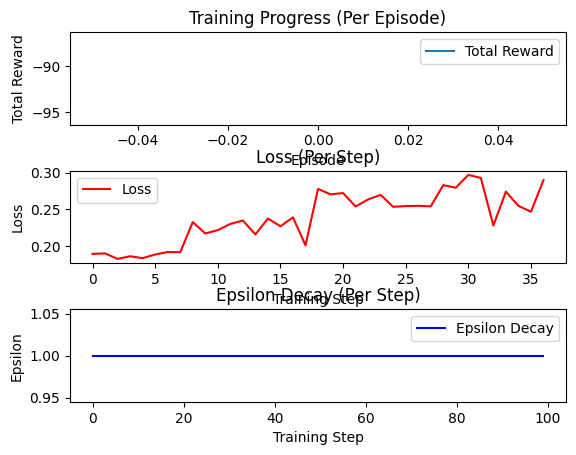

<Figure size 640x480 with 0 Axes>

Episode 1/500, Total Reward: -91.34928753624342
Loss: 0.24974189225966714
Loss: 0.2763567435765847
Loss: 0.3045342379625544
Loss: 0.2440384625780844
Loss: 0.2787644484425898
Loss: 0.2559509586327253
Loss: 0.23490733223411614
Loss: 0.22619795498138262
Loss: 0.21992147530868664
Loss: 0.21691182273969323
Loss: 0.18352311100164143
Loss: 0.22618518117711828
Loss: 0.1930361979251095
Loss: 0.18848095870173476
Loss: 0.19746615761739644
Loss: 0.22071754705488403
Loss: 0.2065527646721781
Loss: 0.16989653817770559
Loss: 0.1644327453880553
Loss: 0.1713092775815542
Loss: 0.1560216172894272
Loss: 0.2078496628454173
Loss: 0.1895139148963193
Loss: 0.18164018393244885
Loss: 0.18392309408320345
Loss: 0.18341830475374446
Loss: 0.14927247139828204
Loss: 0.15154209812736297
Loss: 0.1456734061956479
Loss: 0.13927203495126073
Loss: 0.11650521064494015
Loss: 0.1527091193220756
Loss: 0.18766517110091435
Loss: 0.19392903395399025
Loss: 0.14808795320367596
Loss: 0.14018234209053088
Loss: 0.1101816060239794
Loss:

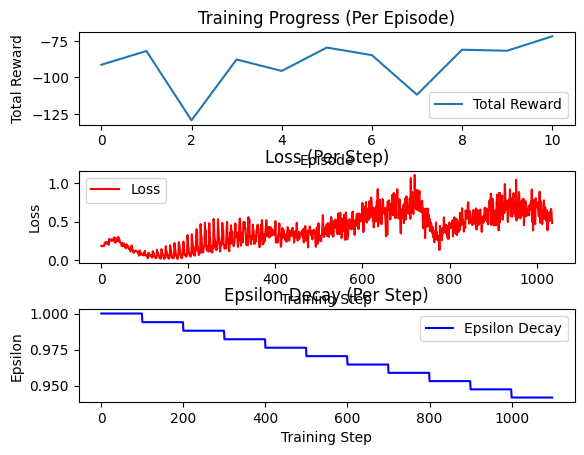

<Figure size 640x480 with 0 Axes>

Episode 11/500, Total Reward: -71.85028987259945
Loss: 0.6947282689845424
Loss: 0.37994108926993
Loss: 0.45165749947622524
Loss: 0.4516565334121655
Loss: 0.656702312121606
Loss: 0.40107571200047437
Loss: 0.4471417244606736
Loss: 0.5421807559054912
Loss: 0.47379632725899234
Loss: 0.3722050227837349
Loss: 0.28085262359412466
Loss: 0.45597228973677195
Loss: 0.3093075296205523
Loss: 0.37752393768947384
Loss: 0.4311341814982189
Loss: 0.4032622054952397
Loss: 0.4500983495354815
Loss: 0.4462178072409554
Loss: 0.3952422634868165
Loss: 0.5035263191332042
Loss: 0.31527180333596594
Loss: 0.4858963254602159
Loss: 0.6394774933688984
Loss: 0.4416842500182634
Loss: 0.5552728794898342
Loss: 0.5805533548952733
Loss: 0.4658227775456163
Loss: 0.3791747070858875
Loss: 0.47415124902980654
Loss: 0.5895690014546536
Loss: 0.3836364048002241
Loss: 0.39029196216073037
Loss: 0.34143751763764163
Loss: 0.3987373087574675
Loss: 0.3603913876846372
Loss: 0.35736838992863756
Loss: 0.4576247098664312
Loss: 0.3827381778

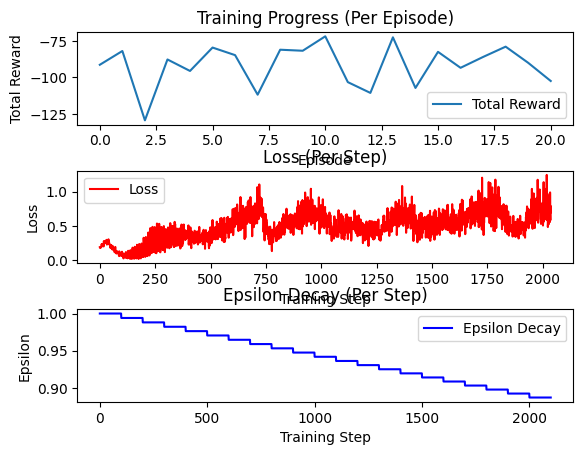

<Figure size 640x480 with 0 Axes>

Episode 21/500, Total Reward: -102.47237418951461
Loss: 1.0380619184734285
Loss: 0.6594263675257266
Loss: 0.7554220988671401
Loss: 0.8007607098050776
Loss: 0.8855143972100841
Loss: 0.7459072815487245
Loss: 0.9990026208424865
Loss: 0.9545591083618132
Loss: 1.237196636634969
Loss: 0.608543684829086
Loss: 0.6429679076227601
Loss: 0.7542579668998941
Loss: 1.0440522454323933
Loss: 0.9395732380872113
Loss: 1.1819934078916496
Loss: 0.7409928863505617
Loss: 1.2996289937504735
Loss: 0.7946671776800597
Loss: 1.0293274015553735
Loss: 0.8312251110603598
Loss: 0.7748094056738479
Loss: 0.9647171460750157
Loss: 0.8352066239757592
Loss: 1.1056628690136028
Loss: 0.7438670082575177
Loss: 1.228534421709989
Loss: 1.0933915387492512
Loss: 0.7795530003959514
Loss: 0.7060527173003827
Loss: 0.3532731958715133
Loss: 0.7367834548054122
Loss: 1.0175840278642516
Loss: 0.7097799809577577
Loss: 1.0700581532576794
Loss: 0.6077776146579812
Loss: 0.8280302066397198
Loss: 0.8146431981270045
Loss: 0.8578339366749598
Los

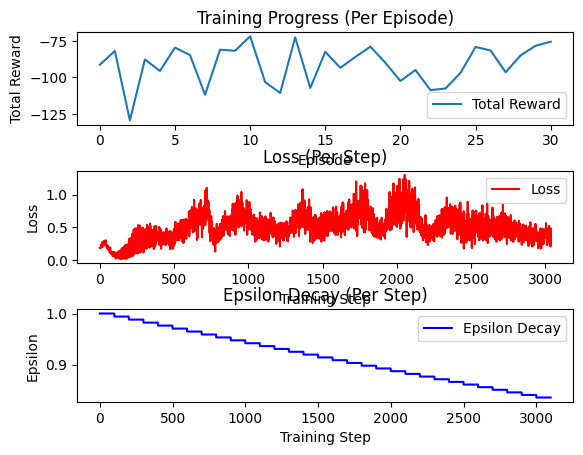

<Figure size 640x480 with 0 Axes>

Episode 31/500, Total Reward: -75.52617554851416
Loss: 0.37410868610033177
Loss: 0.23007502063082114
Loss: 0.29349686316517964
Loss: 0.2504060644058489
Loss: 0.24528458491853156
Loss: 0.21628073556253008
Loss: 0.33971094443102845
Loss: 0.3561554765528338
Loss: 0.26059099369068905
Loss: 0.5739001031092212
Loss: 0.41721326366246686
Loss: 0.36781085914733413
Loss: 0.6339711451526213
Loss: 0.28255968433072826
Loss: 0.2636144924585354
Loss: 0.2410993255250829
Loss: 0.2995828096136184
Loss: 0.2715570303837437
Loss: 0.37370160097398897
Loss: 0.32964572166589207
Loss: 0.22037987477603552
Loss: 0.3882862949334509
Loss: 0.45312572336138035
Loss: 0.41992152369585634
Loss: 0.18626794072098735
Loss: 0.3758113700451112
Loss: 0.3588231051192641
Loss: 0.3901837363416183
Loss: 0.39388585041835134
Loss: 0.430758941766559
Loss: 0.3684526325897014
Loss: 0.46572364821265805
Loss: 0.4625026369289976
Loss: 0.35069515354771646
Loss: 0.4000348882672592
Loss: 0.439368119414678
Loss: 0.386846541132452
Loss: 0.44

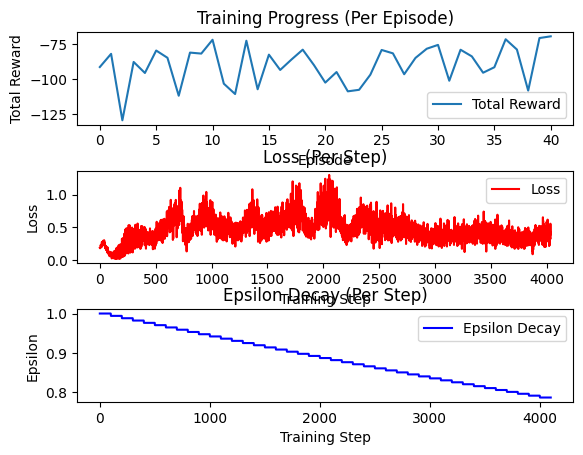

<Figure size 640x480 with 0 Axes>

Episode 41/500, Total Reward: -69.39966887361282
Loss: 0.5069980727933808
Loss: 0.5011333255692467
Loss: 0.41313596189177726
Loss: 0.44245284656373246
Loss: 0.4094336840464323
Loss: 0.35404552098498715
Loss: 0.4665827036498669
Loss: 0.2815302866197709
Loss: 0.516712298041426
Loss: 0.3158020262718486
Loss: 0.3842051061938897
Loss: 0.5069371875325759
Loss: 0.32388048346695714
Loss: 0.4710012015827714
Loss: 0.38179635947950424
Loss: 0.6738798815045793
Loss: 0.4380378720738436
Loss: 0.6840671976246042
Loss: 0.36862130518894437
Loss: 0.45579409134227994
Loss: 0.3885259237435031
Loss: 0.5979523312101007
Loss: 0.3627831352243414
Loss: 0.2904502494510357
Loss: 0.4872934401004668
Loss: 0.5025709381768636
Loss: 0.4206776047888203
Loss: 0.3963255015363115
Loss: 0.29009933921359476
Loss: 0.45651824394817236
Loss: 0.5177968187767473
Loss: 0.29668221151982943
Loss: 0.4252535685534462
Loss: 0.435826304979001
Loss: 0.38198705794887533
Loss: 0.3805506684726842
Loss: 0.4645001836585984
Loss: 0.396319190

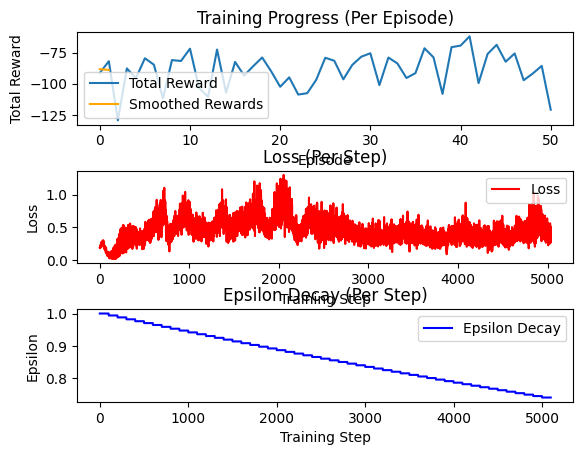

<Figure size 640x480 with 0 Axes>

Episode 51/500, Total Reward: -120.89897087636076
Loss: 0.4790901266662843
Loss: 0.3574005197625492
Loss: 0.24536703883001548
Loss: 0.2695505170870055
Loss: 0.4730654555852635
Loss: 0.519052630922825
Loss: 0.30355474288270656
Loss: 0.32513930338321506
Loss: 0.45721648237979823
Loss: 0.23073403014870913
Loss: 0.4077469354124972
Loss: 0.22558775660782618
Loss: 0.4232174541695972
Loss: 0.37785560407322705
Loss: 0.28367812542258264
Loss: 0.5162334651306674
Loss: 0.22520906701138885
Loss: 0.48766111956511726
Loss: 0.3620403302882707
Loss: 0.5386774102170808
Loss: 0.2889888544572727
Loss: 0.37651369634824855
Loss: 0.2967962074665579
Loss: 0.3665615596282954
Loss: 0.3686571964421644
Loss: 0.3146849771150101
Loss: 0.3594466448577204
Loss: 0.3520797204287477
Loss: 0.34671605244156956
Loss: 0.2927621778580052
Loss: 0.38900160527903055
Loss: 0.27991668037300144
Loss: 0.22789223483566443
Loss: 0.38544049442151185
Loss: 0.21202309582973794
Loss: 0.4178540190853461
Loss: 0.42127142769556347
Loss: 0.

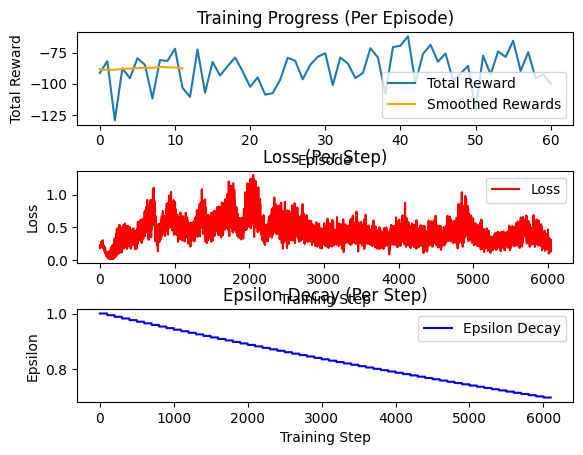

<Figure size 640x480 with 0 Axes>

Episode 61/500, Total Reward: -100.04193446001294
Loss: 0.39434178167084255
Loss: 0.2711325974827129
Loss: 0.1429194475282786
Loss: 0.16645101649945848
Loss: 0.27391715045166776
Loss: 0.24538757681410503
Loss: 0.3512935308306818
Loss: 0.2341602882984576
Loss: 0.3023948532152174
Loss: 0.17417362956845542
Loss: 0.2633758613841082
Loss: 0.2432276407563918
Loss: 0.3945218895401141
Loss: 0.3049577958501513
Loss: 0.2820345551122953
Loss: 0.188701487890866
Loss: 0.3449332612059719
Loss: 0.22375544452259105
Loss: 0.28185263480512013
Loss: 0.2897426171914006
Loss: 0.27251421715176305
Loss: 0.2206417473759575
Loss: 0.2609660246080422
Loss: 0.28856526584968184
Loss: 0.2576236559550557
Loss: 0.1519088765056313
Loss: 0.3065949376129344
Loss: 0.3033869724120681
Loss: 0.1997313075109867
Loss: 0.15382243464129713
Loss: 0.2840527169999437
Loss: 0.19678305284035102
Loss: 0.2236000675835628
Loss: 0.21924857309571882
Loss: 0.17909381300160185
Loss: 0.2625799551446004
Loss: 0.2151405480633397
Loss: 0.36339

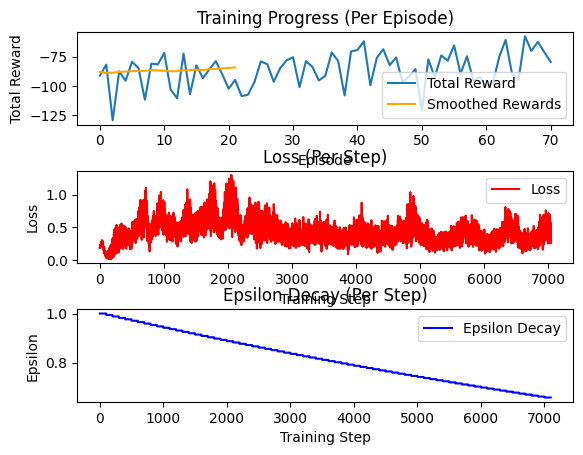

<Figure size 640x480 with 0 Axes>

Episode 71/500, Total Reward: -79.67754902566686
Loss: 0.3632766020012387
Loss: 0.44871014419020133
Loss: 0.3770965447341276
Loss: 0.341397991552035
Loss: 0.4498454230594244
Loss: 0.47297033103897457
Loss: 0.46917923708163534
Loss: 0.2964097086734336
Loss: 0.43048090678340545
Loss: 0.26918814349624254
Loss: 0.3870438777872707
Loss: 0.35283378975508917
Loss: 0.6494191762862743
Loss: 0.427919322900467
Loss: 0.3769963942457642
Loss: 0.4428168457992617
Loss: 0.41702607117113233
Loss: 0.32311323704537354
Loss: 0.4958026537338722
Loss: 0.3843188967864738
Loss: 0.49505691444259725
Loss: 0.49650863787533484
Loss: 0.38849001662805904
Loss: 0.3817410332770681
Loss: 0.22900818462890896
Loss: 0.4749789775106876
Loss: 0.4090755177180018
Loss: 0.42631118005214413
Loss: 0.40960407708583846
Loss: 0.3778609050906593
Loss: 0.36283746001140627
Loss: 0.5246328429806425
Loss: 0.3036708250220719
Loss: 0.4869322236919701
Loss: 0.4093695255368569
Loss: 0.4624653094401231
Loss: 0.3795127950466122
Loss: 0.34543

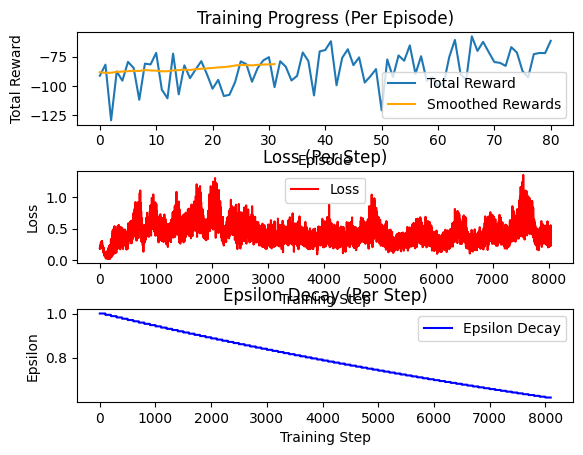

<Figure size 640x480 with 0 Axes>

Episode 81/500, Total Reward: -61.55599086664639
Loss: 0.48551388545037466
Loss: 0.23452989390941745
Loss: 0.407983161993009
Loss: 0.37669063144312626
Loss: 0.3489574744649988
Loss: 0.27849390244842337
Loss: 0.4253481351094871
Loss: 0.46859132005113535
Loss: 0.4658981019748033
Loss: 0.5047498904811369
Loss: 0.3354543526502083
Loss: 0.38713207884401
Loss: 0.29082347735279046
Loss: 0.5934979349747255
Loss: 0.19105491323959747
Loss: 0.4590098177497006
Loss: 0.46699627789118126
Loss: 0.30477003606821834
Loss: 0.32180579363670714
Loss: 0.22920122347240507
Loss: 0.3585635982015968
Loss: 0.4503227369683425
Loss: 0.28609945357022937
Loss: 0.3500573371414436
Loss: 0.5152652198033298
Loss: 0.32319031378588936
Loss: 0.32380537553398303
Loss: 0.3049243217451789
Loss: 0.5265788195785089
Loss: 0.3107392927071745
Loss: 0.41247918739165734
Loss: 0.5739377997168408
Loss: 0.29003711802638554
Loss: 0.33159128974556457
Loss: 0.3382056893739007
Loss: 0.23567831815057994
Loss: 0.390954327603544
Loss: 0.2782

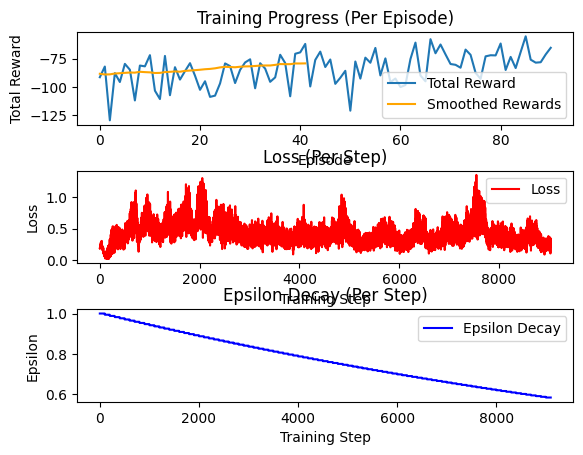

<Figure size 640x480 with 0 Axes>

Episode 91/500, Total Reward: -65.34678670002894
Loss: 0.17752911558445988
Loss: 0.26694134720087126
Loss: 0.2004036549478281
Loss: 0.21332360826834768
Loss: 0.4107455888066581
Loss: 0.24600876377031766
Loss: 0.46017421647524615
Loss: 0.24656892919455656
Loss: 0.12708975019810895
Loss: 0.18273834170394826
Loss: 0.35313976126415125
Loss: 0.27770401497831637
Loss: 0.2859204585882347
Loss: 0.22049834756993736
Loss: 0.2658462559282393
Loss: 0.2941483666533958
Loss: 0.28579881481029723
Loss: 0.27999787174656127
Loss: 0.26732721596362496
Loss: 0.17812728911773282
Loss: 0.2956745283473403
Loss: 0.30870963493117654
Loss: 0.2559118520454076
Loss: 0.18065247251051425
Loss: 0.21834802305562362
Loss: 0.19324551295751335
Loss: 0.24260532277464902
Loss: 0.29321779068113063
Loss: 0.3060604287062132
Loss: 0.2620960272287701
Loss: 0.25421221505978797
Loss: 0.12459456653361198
Loss: 0.24524192372733267
Loss: 0.24752891949061762
Loss: 0.23766369807541488
Loss: 0.10946739471328543
Loss: 0.2384173914104126

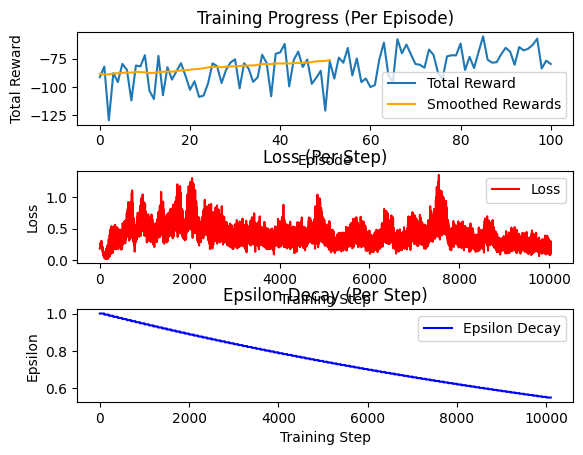

<Figure size 640x480 with 0 Axes>

Episode 101/500, Total Reward: -79.63747566122332
Loss: 0.27568807296805564
Loss: 0.17360303886462064
Loss: 0.3106877111451946
Loss: 0.2496054650197166
Loss: 0.15012439015646584
Loss: 0.2400239323341134
Loss: 0.3984490409551231
Loss: 0.17264983160782238
Loss: 0.14281011735158164
Loss: 0.15567302725787585
Loss: 0.15503514439409832
Loss: 0.11652735242444687
Loss: 0.12743106985279318
Loss: 0.27444067719852416
Loss: 0.2268575786427014
Loss: 0.25008686160019983
Loss: 0.16758856793417648
Loss: 0.23414450631624947
Loss: 0.19569047845095344
Loss: 0.30175076660796296
Loss: 0.09283267709837575
Loss: 0.10993385910022997
Loss: 0.18866829679858726
Loss: 0.2790340374917485
Loss: 0.2967228180314431
Loss: 0.2301238796899977
Loss: 0.13664493431358185
Loss: 0.11242195507605207
Loss: 0.1300606757959828
Loss: 0.25934118869537587
Loss: 0.2493677741613899
Loss: 0.16502081148937908
Loss: 0.238471612794265
Loss: 0.19393776860306744
Loss: 0.1670139089775545
Loss: 0.21726280020787425
Loss: 0.28486599154368053
L

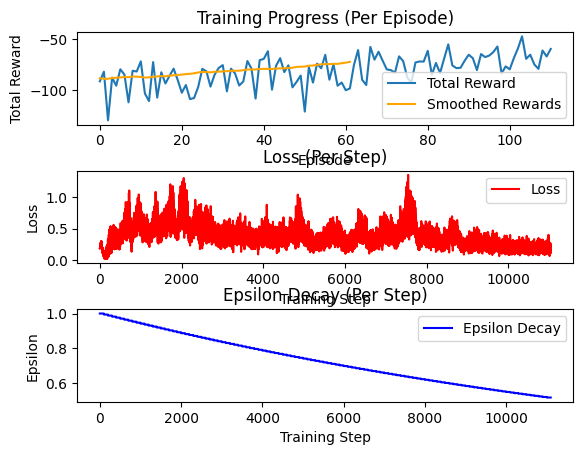

<Figure size 640x480 with 0 Axes>

Episode 111/500, Total Reward: -59.6784928422842
Loss: 0.12970341503111976
Loss: 0.13721962188696224
Loss: 0.16265120843672598
Loss: 0.1334570094624454
Loss: 0.18143888189277907
Loss: 0.1182795522178943
Loss: 0.22507924489704387
Loss: 0.18597508871307783
Loss: 0.2639188918139038
Loss: 0.11890978191244501
Loss: 0.2102928301599072
Loss: 0.23535348260953676
Loss: 0.12124678814175585
Loss: 0.09213308046778802
Loss: 0.16204045026483152
Loss: 0.13084848060452084
Loss: 0.14695137596488989
Loss: 0.24439040153403396
Loss: 0.17480869204776792
Loss: 0.11082996234753065
Loss: 0.18320224694981782
Loss: 0.09737865451855421
Loss: 0.14012545891174097
Loss: 0.15981232887395452
Loss: 0.11295759397239523
Loss: 0.17381494919213294
Loss: 0.1635002531614828
Loss: 0.16543029889414107
Loss: 0.2132080340559863
Loss: 0.13374448671633943
Loss: 0.4301506999309102
Loss: 0.2440470533969598
Loss: 0.1480569778788181
Loss: 0.1972988863285029
Loss: 0.11725400552832721
Loss: 0.24896226160641116
Loss: 0.15566148015819423

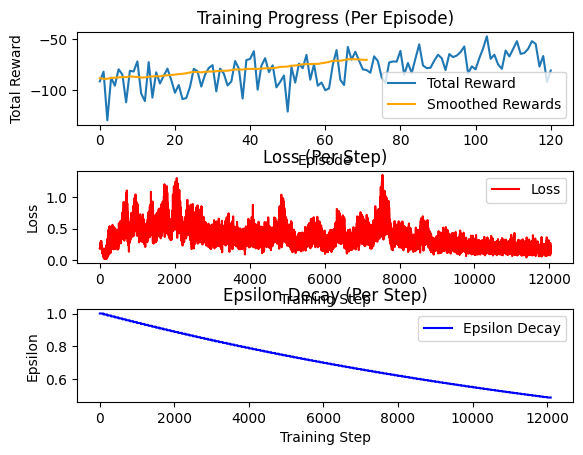

<Figure size 640x480 with 0 Axes>

Episode 121/500, Total Reward: -80.7742276452385
Loss: 0.15550805847550858
Loss: 0.15003790547067006
Loss: 0.2287322894024671
Loss: 0.16781184003214783
Loss: 0.22290153333130036
Loss: 0.11298890389260237
Loss: 0.21951572947811354
Loss: 0.11924225624866719
Loss: 0.18857479778848302
Loss: 0.15886635880757877
Loss: 0.12116841273476911
Loss: 0.21815227208689442
Loss: 0.18725092849264768
Loss: 0.09679607035500165
Loss: 0.24861084779030412
Loss: 0.19970012229412357
Loss: 0.1207135851122052
Loss: 0.10217114889319151
Loss: 0.10303828427846974
Loss: 0.1953947021785116
Loss: 0.12732498087227334
Loss: 0.12547004851975108
Loss: 0.12976143008095453
Loss: 0.1077246650629996
Loss: 0.10909810570502644
Loss: 0.20153808532328038
Loss: 0.18558031544137543
Loss: 0.13125672434571017
Loss: 0.10065378976396519
Loss: 0.1796060239177925
Loss: 0.24129488152268375
Loss: 0.1907818024674327
Loss: 0.11746133075008622
Loss: 0.09853465347303739
Loss: 0.15081657090211156
Loss: 0.13681964235396027
Loss: 0.1598914669346

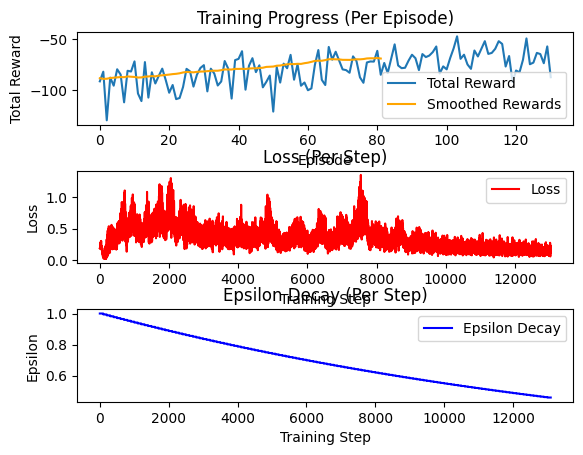

<Figure size 640x480 with 0 Axes>

Episode 131/500, Total Reward: -87.33242332487781
Loss: 0.11576113910638072
Loss: 0.22032961234167617
Loss: 0.14616674899389434
Loss: 0.10191269432750555
Loss: 0.13438608322273177
Loss: 0.1352649565485757
Loss: 0.13504842058196018
Loss: 0.10412236373496761
Loss: 0.13459754966272025
Loss: 0.11355801928342875
Loss: 0.18092020236971507
Loss: 0.10360165549612095
Loss: 0.13181647354983236
Loss: 0.21926604147453127
Loss: 0.11941659389296408
Loss: 0.15751364363395867
Loss: 0.16032337697339083
Loss: 0.10283463783960697
Loss: 0.12075703997325177
Loss: 0.09290251862021692
Loss: 0.18052806506744362
Loss: 0.13363038441913938
Loss: 0.13781328425424383
Loss: 0.2058833898027005
Loss: 0.09991910326425184
Loss: 0.09330837519364411
Loss: 0.09862853220049114
Loss: 0.15704952652715926
Loss: 0.11399117312880275
Loss: 0.174601610235851
Loss: 0.1304085784275283
Loss: 0.23630609690966664
Loss: 0.13758355438719083
Loss: 0.14952458344760905
Loss: 0.18964131244111787
Loss: 0.10115991369267066
Loss: 0.19265252596

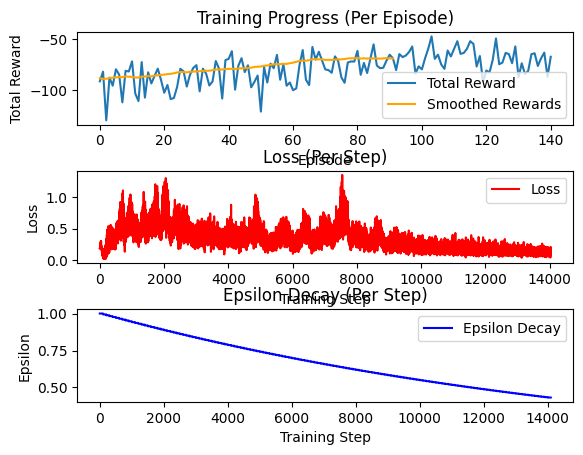

<Figure size 640x480 with 0 Axes>

Episode 141/500, Total Reward: -67.35107140981236
Loss: 0.1100043057532504
Loss: 0.12954852941909872
Loss: 0.12620076256221857
Loss: 0.1522769511533306
Loss: 0.10277258255836573
Loss: 0.11397255762104433
Loss: 0.12994064059572114
Loss: 0.07063469153941601
Loss: 0.12175077015383026
Loss: 0.1053922170762098
Loss: 0.146041470235611
Loss: 0.10876232867266789
Loss: 0.16181420492308443
Loss: 0.09621667740663409
Loss: 0.0970977055151209
Loss: 0.08430641313001452
Loss: 0.149750419757742
Loss: 0.10069673488081243
Loss: 0.05446530900219031
Loss: 0.1116624559722817
Loss: 0.0649807565227348
Loss: 0.1729580355591327
Loss: 0.13109382642165374
Loss: 0.13490983490099653
Loss: 0.11046098621445898
Loss: 0.20218788949543576
Loss: 0.1078891804699451
Loss: 0.09637246950095435
Loss: 0.13971508128920673
Loss: 0.10116705246573737
Loss: 0.09231606984401795
Loss: 0.09969589855895788
Loss: 0.13366079496679567
Loss: 0.09489015441471817
Loss: 0.08585248706148707
Loss: 0.06794471466117333
Loss: 0.09985570502595838


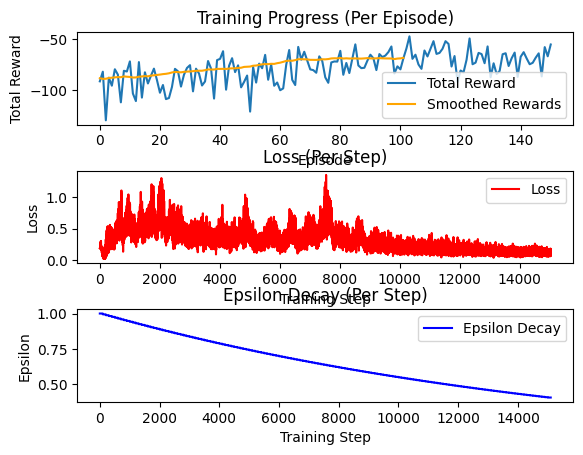

<Figure size 640x480 with 0 Axes>

Episode 151/500, Total Reward: -55.35231306735973
Loss: 0.13152572888045708
Loss: 0.13164215371498011
Loss: 0.06907420494713146
Loss: 0.16060490418185128
Loss: 0.10214461684368617
Loss: 0.09692114450203174
Loss: 0.10686917525411374
Loss: 0.07674276007423379
Loss: 0.10692946258261106
Loss: 0.10674243161364415
Loss: 0.09530163820832158
Loss: 0.047992270738260345
Loss: 0.08507000351389929
Loss: 0.12282565292599758
Loss: 0.1017798156558241
Loss: 0.06969238049619714
Loss: 0.10071485330637055
Loss: 0.11060232131611668
Loss: 0.11257435754365605
Loss: 0.07527866985244863
Loss: 0.10111933334666447
Loss: 0.16301664025274826
Loss: 0.05686088869473004
Loss: 0.16288647230176143
Loss: 0.12358429600409143
Loss: 0.04917140150472138
Loss: 0.09767606999083008
Loss: 0.0631417213444336
Loss: 0.08682161069045381
Loss: 0.06503364331586668
Loss: 0.06996033098245655
Loss: 0.09295132267789377
Loss: 0.13178563462280013
Loss: 0.09039658342674421
Loss: 0.09210253028224442
Loss: 0.10204333878616166
Loss: 0.0831167

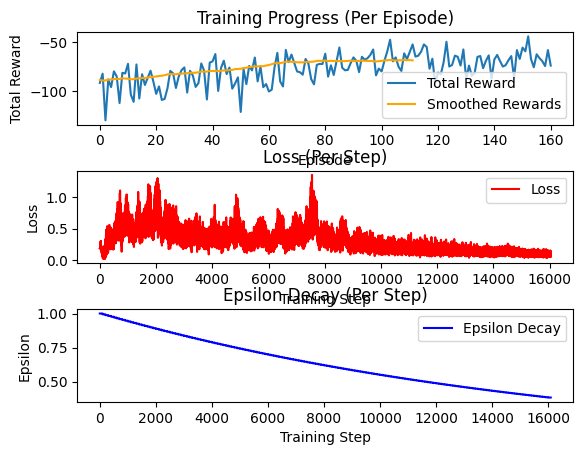

<Figure size 640x480 with 0 Axes>

Episode 161/500, Total Reward: -73.65884824867187
Loss: 0.086553402251661
Loss: 0.08916094064866067
Loss: 0.07742001271580654
Loss: 0.10480107427240881
Loss: 0.08917043368609519
Loss: 0.09258525859732704
Loss: 0.09599989496238445
Loss: 0.07678894522315398
Loss: 0.13479315389967142
Loss: 0.10732973135172709
Loss: 0.07866687204509265
Loss: 0.07539759028544343
Loss: 0.09951839971882889
Loss: 0.0646835948525985
Loss: 0.08815018251491961
Loss: 0.13721620382326685
Loss: 0.05870395344037891
Loss: 0.08573160726854179
Loss: 0.08592165691212499
Loss: 0.07888887299180701
Loss: 0.07430883442848818
Loss: 0.08360987004440348
Loss: 0.12375927724015688
Loss: 0.0938814506884561
Loss: 0.10286998905962662
Loss: 0.11160895489130397
Loss: 0.0482170454294248
Loss: 0.07093883988159168
Loss: 0.09200444034365057
Loss: 0.08851576373266211
Loss: 0.06574147675389101
Loss: 0.07551373442016206
Loss: 0.11365115501045914
Loss: 0.09421567070042969
Loss: 0.1375407286711986
Loss: 0.12215525519888643
Loss: 0.112834983588

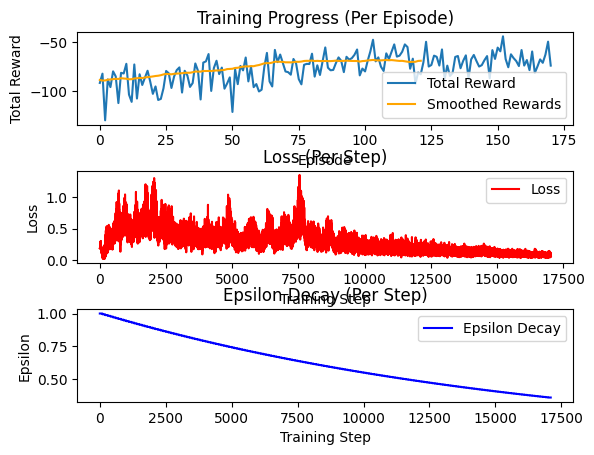

<Figure size 640x480 with 0 Axes>

Episode 171/500, Total Reward: -73.70385503150247
Loss: 0.047189253778075695
Loss: 0.06688278723292512
Loss: 0.07881111200707377
Loss: 0.06097136028091045
Loss: 0.0661133895363322
Loss: 0.10733159494006039
Loss: 0.06336064910978845
Loss: 0.07276761345804693
Loss: 0.08568447019922915
Loss: 0.07608239304009254
Loss: 0.05942314677798087
Loss: 0.06450674764702907
Loss: 0.06683543161740713
Loss: 0.059941818410771834
Loss: 0.046766930576793396
Loss: 0.0671664580809598
Loss: 0.06968558754910109
Loss: 0.10087043082676012
Loss: 0.059611420292149234
Loss: 0.1392717372324895
Loss: 0.09187148886392343
Loss: 0.07420207403263994
Loss: 0.08153687904621924
Loss: 0.06957487534371057
Loss: 0.06792045162346153
Loss: 0.054710108960654244
Loss: 0.08820098216456876
Loss: 0.08908351590282496
Loss: 0.05051772849603693
Loss: 0.11881736194886508
Loss: 0.060141030040551775
Loss: 0.10584059738795903
Loss: 0.07239873749017064
Loss: 0.0588641925631621
Loss: 0.0710016560960787
Loss: 0.06457553971471176
Loss: 0.04942

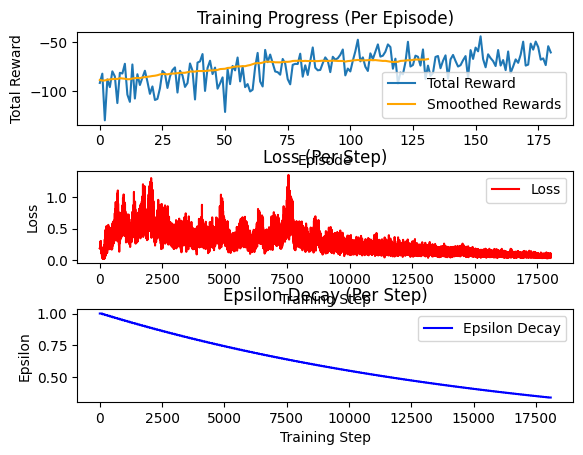

<Figure size 640x480 with 0 Axes>

Episode 181/500, Total Reward: -60.26807446480543
Loss: 0.08038409008383363
Loss: 0.09327175235976651
Loss: 0.05679322775410748
Loss: 0.08953980517273977
Loss: 0.07677787367814853
Loss: 0.06101425599526464
Loss: 0.055788470749565694
Loss: 0.0422947181877566
Loss: 0.06508787502802686
Loss: 0.06299006157294798
Loss: 0.08019226005384571
Loss: 0.0640750034865675
Loss: 0.06939430020509402
Loss: 0.11217139464753799
Loss: 0.07179351307318112
Loss: 0.08191799618237869
Loss: 0.0803675835821834
Loss: 0.056585384899211055
Loss: 0.07764547496033608
Loss: 0.06080354421692795
Loss: 0.07809515394314478
Loss: 0.08604464825630381
Loss: 0.06397369883973539
Loss: 0.06874887083938964
Loss: 0.07499208677900172
Loss: 0.07219174326995134
Loss: 0.04324579598125786
Loss: 0.07816832085360499
Loss: 0.0805514642927304
Loss: 0.043328592572689825
Loss: 0.0796702112012096
Loss: 0.045550797099893944
Loss: 0.048691834606735276
Loss: 0.051752834772227724
Loss: 0.07752937327794303
Loss: 0.06546139368943893
Loss: 0.04376

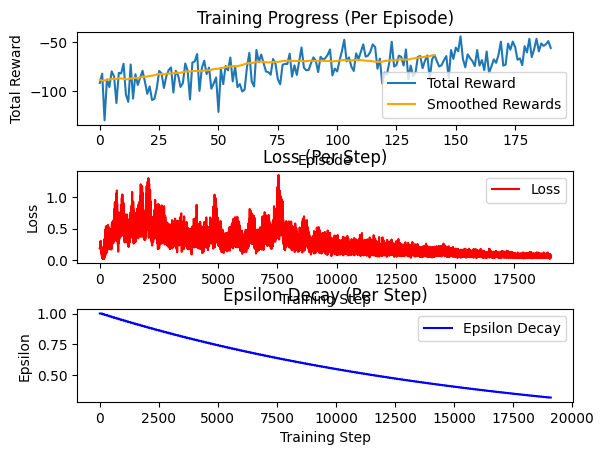

<Figure size 640x480 with 0 Axes>

Episode 191/500, Total Reward: -55.7529381615738
Loss: 0.059937916591554105
Loss: 0.05917212314956413
Loss: 0.033313341183282476
Loss: 0.04892983711155432
Loss: 0.075252177612074
Loss: 0.06454786055406213
Loss: 0.062036759428998035
Loss: 0.04144766907366477
Loss: 0.05839232260868848
Loss: 0.03632090473690415
Loss: 0.04708625939834877
Loss: 0.06976612099653792
Loss: 0.08131765105069788
Loss: 0.03933487803066431
Loss: 0.06116337078146285
Loss: 0.056651844137070334
Loss: 0.07000826097699812
Loss: 0.05058847444076642
Loss: 0.058267448581921386
Loss: 0.050795029332116756
Loss: 0.058893432543042745
Loss: 0.05279310966914377
Loss: 0.07804871899423432
Loss: 0.0757034575121654
Loss: 0.06822330291551254
Loss: 0.06825474174511259
Loss: 0.07892905699561438
Loss: 0.05524965975314763
Loss: 0.03798683253636072
Loss: 0.05081718680785554
Loss: 0.07008278357461303
Loss: 0.04172264672422871
Loss: 0.06266537405699191
Loss: 0.0562605012711061
Loss: 0.11301554986289244
Loss: 0.05523469280836475
Loss: 0.0398

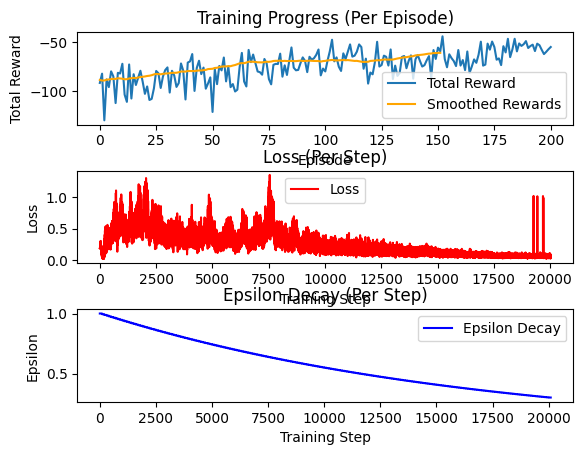

<Figure size 640x480 with 0 Axes>

Episode 201/500, Total Reward: -54.75204494111334
Loss: 0.07287767518651467
Loss: 0.08429725738552604
Loss: 0.04132960971179427
Loss: 0.05659322031633024
Loss: 0.08595730837874711
Loss: 0.04823318173543609
Loss: 0.053312824313273215
Loss: 0.055082735491386786
Loss: 0.06569907497790893
Loss: 0.04627798497019488
Loss: 0.04727661795841434
Loss: 0.04398820334583696
Loss: 0.08379517606350545
Loss: 0.06050656642621938
Loss: 0.06382522429231033
Loss: 0.06670881193524755
Loss: 0.042037648102769776
Loss: 0.07119600024447634
Loss: 0.05524708154362923
Loss: 0.06452738891490056
Loss: 0.04402404566658044
Loss: 0.03747587022757072
Loss: 0.04790472413690987
Loss: 0.061751886295937336
Loss: 0.07157680821930265
Loss: 0.05258754929649769
Loss: 0.04071944088845532
Loss: 0.05824571502097284
Loss: 0.047623649425945026
Loss: 0.05102377634367127
Loss: 0.06045197172917047
Loss: 0.06998674301818793
Loss: 0.03992970798797055
Loss: 0.03641517869177295
Loss: 0.09497629918363644
Loss: 0.07124318520700873
Loss: 0.0

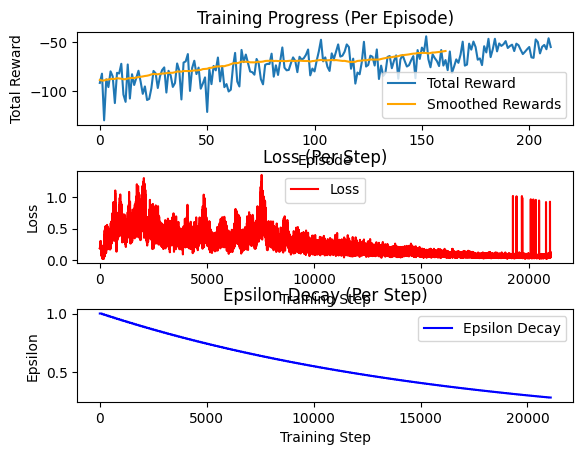

<Figure size 640x480 with 0 Axes>

Episode 211/500, Total Reward: -54.77029791790316
Loss: 0.05710740363005694
Loss: 0.06620240990601069
Loss: 0.07532430765653848
Loss: 0.0716801228124174
Loss: 0.05215599991458237
Loss: 0.04521912248903595
Loss: 0.06875560920779196
Loss: 0.05574391713844297
Loss: 0.07316862086600073
Loss: 0.09198007613755535
Loss: 0.08553984404924558
Loss: 0.07028887371686177
Loss: 0.04176455037766813
Loss: 0.04499396447923955
Loss: 0.06040731854978339
Loss: 0.03733897221091266
Loss: 0.07389892057044259
Loss: 0.06569759473826928
Loss: 0.06196769606039889
Loss: 0.06263957061521164
Loss: 0.06227734588907307
Loss: 0.06775942024461316
Loss: 0.06662165900373557
Loss: 0.07198246099642606
Loss: 0.09355080997737258
Loss: 0.04836279591696173
Loss: 0.060774504177459436
Loss: 0.06417028259165389
Loss: 0.05412529249694971
Loss: 0.059678505675732005
Loss: 0.05512899549120869
Loss: 0.05736519869500527
Loss: 0.06681526331860048
Loss: 0.05250181869239738
Loss: 0.0868696994003773
Loss: 0.06330245285125535
Loss: 0.065508

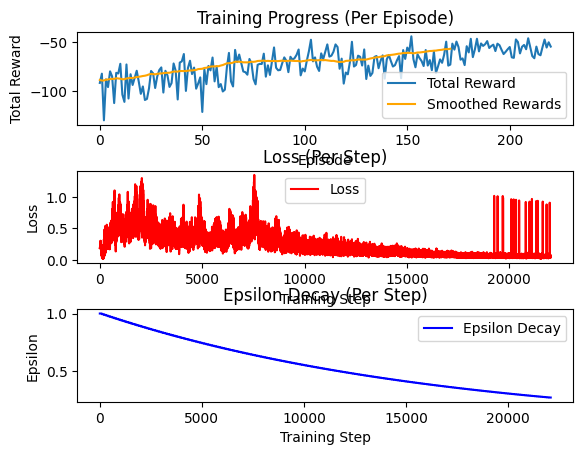

<Figure size 640x480 with 0 Axes>

Episode 221/500, Total Reward: -54.30878441354142
Loss: 0.0696028662884747
Loss: 0.038668748149546024
Loss: 0.05919186291461899
Loss: 0.04787092411569644
Loss: 0.061721295977918714
Loss: 0.045594074242432746
Loss: 0.046105811063834976
Loss: 0.04089776198536955
Loss: 0.06797785398108919
Loss: 0.05847961513954315
Loss: 0.0734462884851868
Loss: 0.040876261624390564
Loss: 0.04883494923517952
Loss: 0.032060524352015514
Loss: 0.056454328046420185
Loss: 0.05657812301603368
Loss: 0.0712624876964313
Loss: 0.040610883779004715
Loss: 0.050334109058441386
Loss: 0.06100813255077555
Loss: 0.06103638564875681
Loss: 0.05653834127982045
Loss: 0.06397732131012536
Loss: 0.030018223030303378
Loss: 0.03953455759887484
Loss: 0.03294772873740352
Loss: 0.04209138876242535
Loss: 0.05245342360998239
Loss: 0.059608153659348025
Loss: 0.06366009462462086
Loss: 0.05526940427664918
Loss: 0.0666389708359888
Loss: 0.04846104944849343
Loss: 0.04296988031031752
Loss: 0.04963503103017229
Loss: 0.05604638742421718
Loss: 0

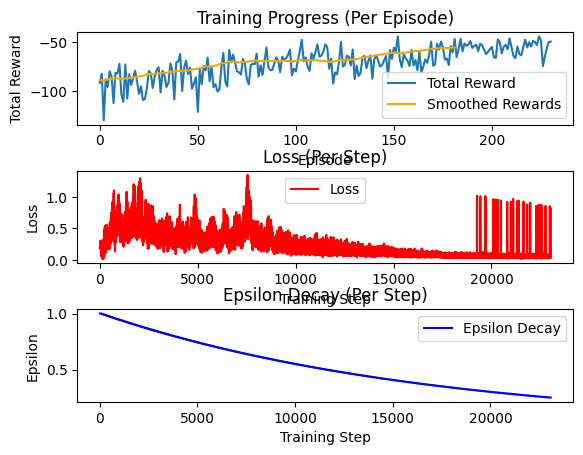

<Figure size 640x480 with 0 Axes>

Episode 231/500, Total Reward: -49.22601095456579
Loss: 0.04639123038844517
Loss: 0.036995877642567274
Loss: 0.04327508285576951
Loss: 0.059225589474674094
Loss: 0.04500914405470867
Loss: 0.07207109314613533
Loss: 0.042757226037886675
Loss: 0.05535174438752913
Loss: 0.04379789702008482
Loss: 0.06586939462193055
Loss: 0.04617804707984932
Loss: 0.025238551225279078
Loss: 0.0367061801091098
Loss: 0.04199269184375372
Loss: 0.04048037343189985
Loss: 0.04011313815643676
Loss: 0.05593623517372818
Loss: 0.04589730133805872
Loss: 0.04863888512220561
Loss: 0.05353076543789268
Loss: 0.031437607913876134
Loss: 0.04544375352128417
Loss: 0.07607992664803288
Loss: 0.05517662790349208
Loss: 0.04089791782199621
Loss: 0.03235142875420427
Loss: 0.04786060244371662
Loss: 0.04147361234902819
Loss: 0.03442709521472474
Loss: 0.04364246213143902
Loss: 0.04791046688134233
Loss: 0.03317377806257262
Loss: 0.03053623668262275
Loss: 0.045299806751733805
Loss: 0.06436768198343892
Loss: 0.044979604899787126
Loss: 0.

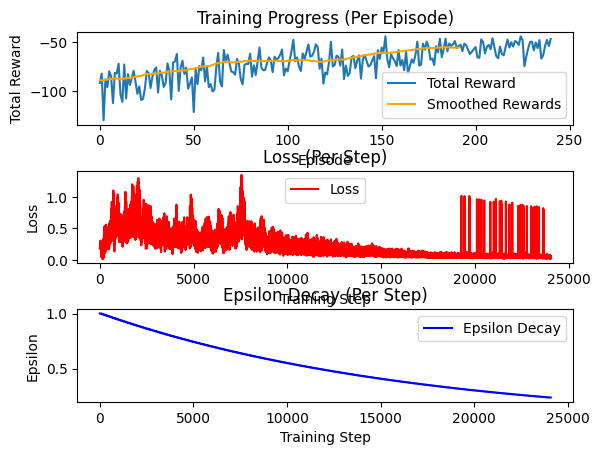

<Figure size 640x480 with 0 Axes>

Episode 241/500, Total Reward: -46.61919837161819
Loss: 0.028724117140402454
Loss: 0.04163847473435156
Loss: 0.04916931741995444
Loss: 0.04232225892148786
Loss: 0.04289149201488421
Loss: 0.03467195917420963
Loss: 0.03637220882017178
Loss: 0.038450022753595825
Loss: 0.04608210636948805
Loss: 0.032582379814471846
Loss: 0.04550951060032038
Loss: 0.027994672474873198
Loss: 0.033632528789084445
Loss: 0.06068271518288
Loss: 0.04187539858865492
Loss: 0.07161060908127001
Loss: 0.03379395603939877
Loss: 0.05590143087371146
Loss: 0.060127684064731304
Loss: 0.0331562465946844
Loss: 0.038674191623665186
Loss: 0.05393633108569927
Loss: 0.03552957137005421
Loss: 0.04897773697682367
Loss: 0.038765352209102
Loss: 0.049930550104548894
Loss: 0.03987568603393591
Loss: 0.03654901241203039
Loss: 0.03130023468211346
Loss: 0.040681143704512465
Loss: 0.058729777135372245
Loss: 0.03807626634164873
Loss: 0.03661514651052537
Loss: 0.03251033294885673
Loss: 0.04250548672115381
Loss: 0.03998299434921353
Loss: 0.01

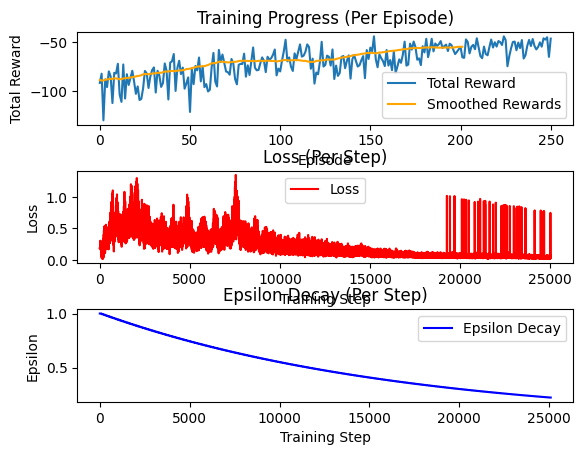

<Figure size 640x480 with 0 Axes>

Episode 251/500, Total Reward: -46.17797174677977
Loss: 0.060780659116849683
Loss: 0.03981727366188702
Loss: 0.03681659502573528
Loss: 0.05776682033185258
Loss: 0.032848121046058394
Loss: 0.04759039122924059
Loss: 0.040071286123017455
Loss: 0.03262296405584654
Loss: 0.03346087489225842
Loss: 0.036196746044456
Loss: 0.034437896884191216
Loss: 0.030770080966990514
Loss: 0.028988759127469513
Loss: 0.03296031615358627
Loss: 0.037516237091793504
Loss: 0.035594159253779546
Loss: 0.04021053622723236
Loss: 0.06432969938576416
Loss: 0.04162232181279158
Loss: 0.043576604795471346
Loss: 0.035016464932497895
Loss: 0.04842751176621047
Loss: 0.036299708553304486
Loss: 0.04510570365873347
Loss: 0.03116591478753567
Loss: 0.04621936132000644
Loss: 0.03939372947361296
Loss: 0.06661722108526802
Loss: 0.043852475712833135
Loss: 0.04781402300696204
Loss: 0.06748470140504884
Loss: 0.04586099929010587
Loss: 0.052582376054235824
Loss: 0.041037489469634564
Loss: 0.06027877917280067
Loss: 0.055441686923557415
L

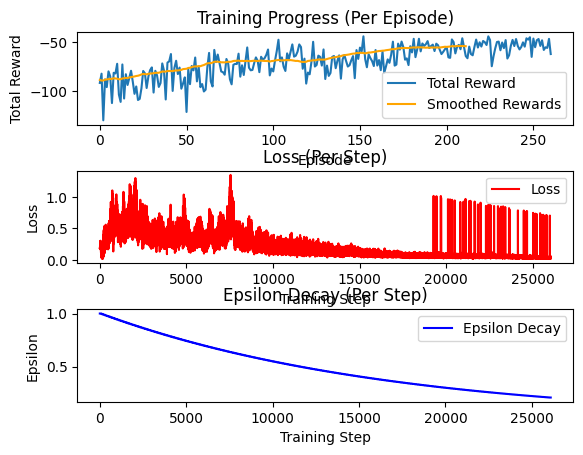

<Figure size 640x480 with 0 Axes>

Episode 261/500, Total Reward: -61.92149096227467
Loss: 0.02322512931842652
Loss: 0.026746119745966093
Loss: 0.03238631135709812
Loss: 0.02987063855870915
Loss: 0.02634131386768426
Loss: 0.024830081669478626
Loss: 0.02599195590945047
Loss: 0.026386313725236903
Loss: 0.031221232685260863
Loss: 0.0454507275428305
Loss: 0.024079977175643506
Loss: 0.023307148202399892
Loss: 0.03757744246648115
Loss: 0.030659511177208894
Loss: 0.024540617168330194
Loss: 0.019870001304201423
Loss: 0.02960217253399453
Loss: 0.040651004378430194
Loss: 0.02863839105509392
Loss: 0.027623818282908143
Episode 262 finished after 20 steps
Episode 262/500, Total Reward: -6.420553775576691
Loss: 0.025418610561929424
Loss: 0.02276978059941781
Loss: 0.02218900086740499
Loss: 0.023814744070651688
Loss: 0.031123388268322557
Loss: 0.02579016436618129
Loss: 0.031238986143049177
Loss: 0.03953372424758099
Loss: 0.031973070369562484
Loss: 0.04939301162843724
Loss: 0.042251916298228574
Loss: 0.027400642566212302
Loss: 0.0287186

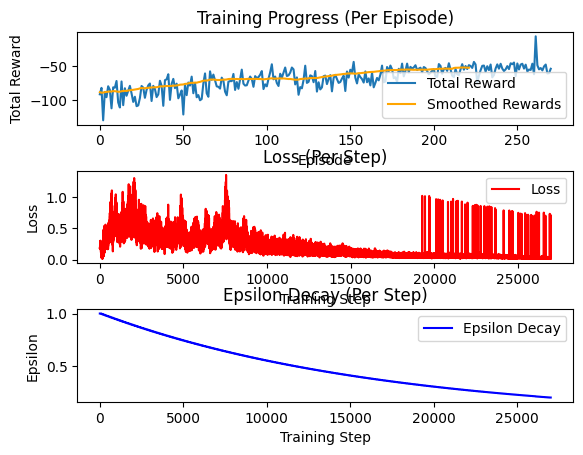

<Figure size 640x480 with 0 Axes>

Episode 271/500, Total Reward: -53.92888097584615
Loss: 0.01740873118892689
Loss: 0.018248446744353875
Loss: 0.031248180031802485
Loss: 0.024093555890141522
Loss: 0.034781465363253695
Loss: 0.01860666710356267
Loss: 0.024507470708143058
Loss: 0.03050180819163332
Loss: 0.025312193693533158
Loss: 0.018665695267654867
Loss: 0.032221483196247167
Loss: 0.031641346543551295
Loss: 0.0291936982448495
Loss: 0.03140660086497946
Loss: 0.027235372590600923
Loss: 0.03421195153735461
Loss: 0.031073352265083603
Loss: 0.028967905238228443
Loss: 0.023037444852052662
Loss: 0.02114103646658873
Loss: 0.018159456459294235
Loss: 0.02840063901165343
Loss: 0.023333912241877273
Loss: 0.024549298329779992
Loss: 0.025436809288599985
Loss: 0.028118811169827458
Loss: 0.02733654477838491
Loss: 0.034584256330385796
Loss: 0.01674703816965567
Loss: 0.03167722826181872
Loss: 0.02316129817746827
Loss: 0.03521298747999581
Loss: 0.025530733118576288
Loss: 0.01875965672392256
Loss: 0.03226441388049982
Loss: 0.0249003339219

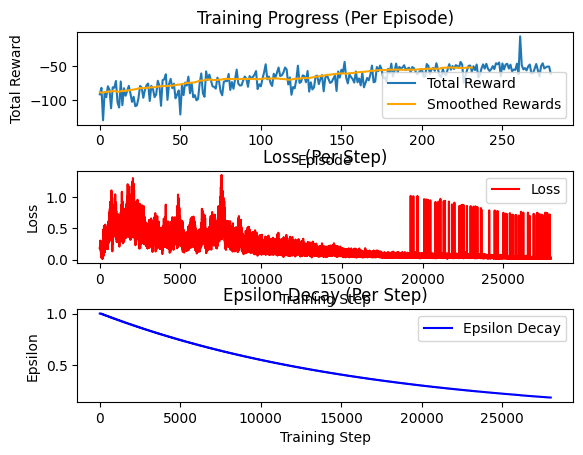

<Figure size 640x480 with 0 Axes>

Episode 281/500, Total Reward: -61.09179668954581
Loss: 0.022681079001447065
Loss: 0.02327865313521761
Loss: 0.01879277646761096
Loss: 0.015717973348310897
Loss: 0.02181014558147821
Loss: 0.02696383218929208
Loss: 0.030367156469766416
Loss: 0.030671497723773485
Loss: 0.03905557431565625
Loss: 0.025250350426235975
Loss: 0.03045008339302168
Loss: 0.024216223054502488
Loss: 0.02326401084865711
Loss: 0.021915878477161175
Loss: 0.023156042899394658
Loss: 0.037313544040477306
Loss: 0.7174958846698014
Loss: 0.019406032143478087
Loss: 0.03205661809987263
Loss: 0.02798926972874589
Loss: 0.026462375886649993
Loss: 0.03252676706805545
Loss: 0.022634735068698036
Loss: 0.022572952730366268
Loss: 0.01643871895293953
Loss: 0.02887518434428089
Loss: 0.02217501351504797
Loss: 0.022624639319165543
Loss: 0.031139999545925164
Loss: 0.7612209675055928
Loss: 0.027549752372171943
Loss: 0.01678094889921281
Loss: 0.03119107497563791
Loss: 0.02503056964394547
Loss: 0.02460103038066572
Loss: 0.029581460340821375

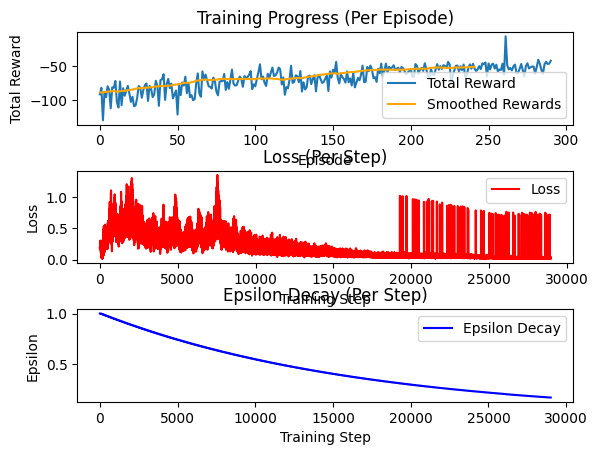

<Figure size 640x480 with 0 Axes>

Episode 291/500, Total Reward: -42.257103782921334
Loss: 0.022795654909606545
Loss: 0.02142580431484748
Loss: 0.02346365990677815
Loss: 0.022377534139731668
Loss: 0.027781818184619007
Loss: 0.03131939068976225
Loss: 0.02164938936357043
Loss: 0.022728682748790995
Loss: 0.022106975997883267
Loss: 0.026725770380412725
Loss: 0.03711857288365311
Loss: 0.019077004722306008
Loss: 0.028149530059544618
Loss: 0.029218912011907662
Loss: 0.026797816448527096
Loss: 0.029186412970347457
Loss: 0.022397022544596856
Loss: 0.029699305649614607
Loss: 0.025384558555178315
Loss: 0.02726000966095702
Loss: 0.024952721793273444
Loss: 0.020970626024738016
Loss: 0.029417697052305774
Loss: 0.02392007285767954
Loss: 0.030883990599879327
Loss: 0.039998030879809104
Loss: 0.03177435794701004
Loss: 0.015906673733963102
Loss: 0.02464323152536883
Loss: 0.029172306806832266
Loss: 0.033394900491068774
Loss: 0.03326225800583719
Loss: 0.017866146391331154
Loss: 0.030383470158640947
Loss: 0.7541375809348313
Loss: 0.02177426

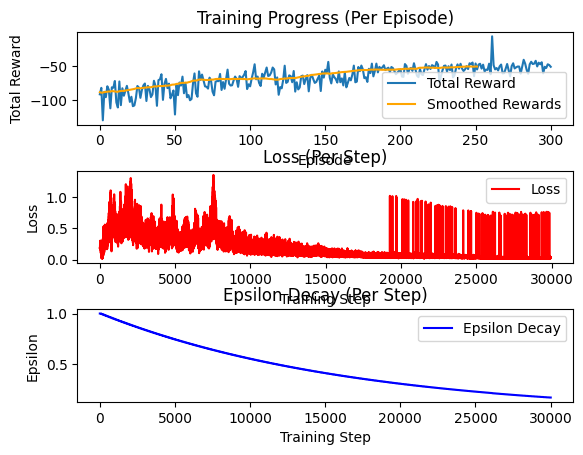

<Figure size 640x480 with 0 Axes>

Episode 301/500, Total Reward: -51.045419164129164
Loss: 0.03915883800879538
Loss: 0.027374698786143504
Loss: 0.04632305961773184
Loss: 0.03381130142012533
Loss: 0.03454582966583753
Loss: 0.02230601691453714
Loss: 0.042465546795017864
Loss: 0.03466593408937435
Loss: 0.032390682124957326
Loss: 0.0297671745141641
Loss: 0.03522902589751817
Loss: 0.023747562428475116
Loss: 0.031702832447674384
Loss: 0.0295837935606292
Loss: 0.025701735320022977
Loss: 0.02172784709707932
Loss: 0.030457544978735526
Loss: 0.029743010620319962
Loss: 0.03713121028648946
Loss: 0.019409549194964203
Loss: 0.03941592668279621
Loss: 0.037951832909373116
Loss: 0.03352410305200876
Loss: 0.021068156412925972
Loss: 0.03395524752036282
Loss: 0.022632962991326857
Loss: 0.02954139724100873
Loss: 0.04009698920679991
Loss: 0.028953413232160465
Loss: 0.03544083288737608
Loss: 0.04737440667210191
Loss: 0.047010429308710376
Loss: 0.03717092599417525
Loss: 0.026854533021512906
Loss: 0.03721031809702438
Loss: 0.023486078202049253

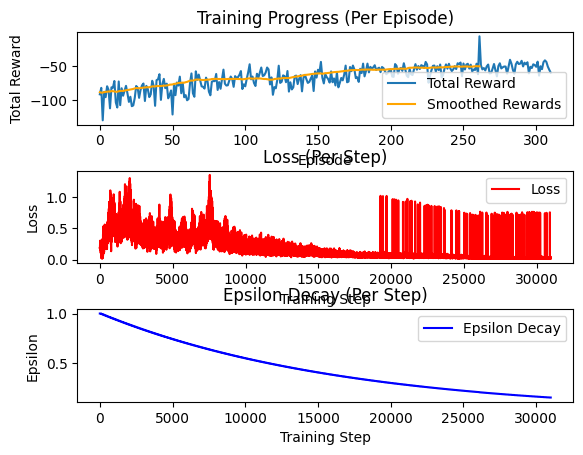

<Figure size 640x480 with 0 Axes>

Episode 311/500, Total Reward: -59.71374838129441
Loss: 0.027053433038825844
Loss: 0.7433052019607633
Loss: 0.0192221602813502
Loss: 0.037873094787730724
Loss: 0.01855069500596481
Loss: 0.027995532157172136
Loss: 0.02776057040065303
Loss: 0.019317017196926238
Loss: 0.02648720940179225
Loss: 0.0274608169022387
Loss: 0.026129412242943597
Loss: 0.023647550252095917
Loss: 0.02696375472853407
Loss: 0.018731604005034763
Loss: 0.0242582859626074
Loss: 0.02391208504727709
Loss: 0.019347533412349578
Loss: 0.02400930995121369
Loss: 0.014892711709617566
Loss: 0.01735714060686535
Loss: 0.024381314767688334
Loss: 0.02493783035542539
Loss: 0.01947398565561469
Loss: 0.026183814774965425
Loss: 0.027306494448639376
Loss: 0.023211277301373002
Loss: 0.025814108756860667
Loss: 0.02238666280575634
Loss: 0.02525733250333917
Loss: 0.024772378001845306
Loss: 0.020776071694058842
Loss: 0.032293618392971235
Loss: 0.022727077578883044
Loss: 0.016401355641784566
Loss: 0.018465200327424134
Loss: 0.0245832458723272

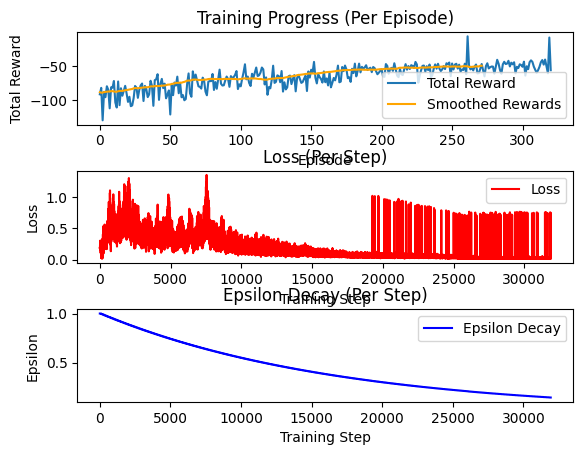

<Figure size 640x480 with 0 Axes>

Episode 321/500, Total Reward: -56.031418822031604
Loss: 0.02534438476522055
Loss: 0.02122266478532717
Loss: 0.026830575317433054
Loss: 0.033903573125774425
Loss: 0.020025121343234656
Loss: 0.023897083314037105
Loss: 0.020727480379388326
Loss: 0.022546491441092616
Loss: 0.022773137375157758
Loss: 0.01766912771030882
Loss: 0.027486347493883886
Loss: 0.02546088172381316
Loss: 0.0239985660721908
Loss: 0.028517062957199704
Loss: 0.0292557324788186
Loss: 0.02275097103414303
Loss: 0.028582645225622184
Loss: 0.02137154365753398
Loss: 0.0283851670663907
Loss: 0.023857579902137112
Loss: 0.019521769536186128
Loss: 0.017806710121441527
Loss: 0.026287574407757437
Loss: 0.020520951141447863
Loss: 0.02446176406152249
Loss: 0.026422709201168022
Loss: 0.025157189114555258
Loss: 0.028064652341948826
Loss: 0.018708692966949443
Loss: 0.030387764157790265
Loss: 0.024220773741449098
Loss: 0.02211964724486664
Loss: 0.023324893532498447
Loss: 0.016328147057313537
Loss: 0.020392951283656348
Loss: 0.0310097560

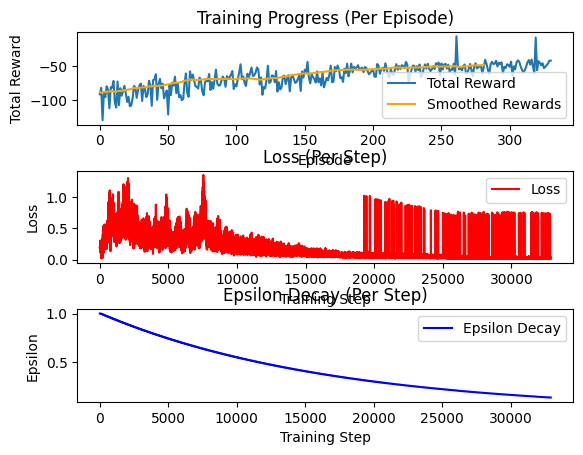

<Figure size 640x480 with 0 Axes>

Episode 331/500, Total Reward: -42.04378995285508
Loss: 0.01669822535073197
Loss: 0.02560048342150674
Loss: 0.018081814968517636
Loss: 0.027072459234183197
Loss: 0.01921562422530823
Loss: 0.030298150381663953
Loss: 0.01946772599804814
Loss: 0.020617006162826773
Loss: 0.025868093379218308
Loss: 0.025657875407453488
Loss: 0.01987159272171775
Loss: 0.019747069335570355
Loss: 0.0204174997239245
Loss: 0.02609606911325093
Loss: 0.024357262743019366
Loss: 0.02607871868623633
Loss: 0.019487140619130438
Loss: 0.020791884288806815
Loss: 0.019578713439610457
Loss: 0.03141447970582956
Loss: 0.017830561084266186
Loss: 0.02006636516406896
Loss: 0.027116960877610584
Loss: 0.02461144648556192
Loss: 0.01499943628366948
Loss: 0.025133313359834666
Loss: 0.015532114527880808
Loss: 0.022475580316975996
Loss: 0.023432563138118624
Loss: 0.022849954913678715
Loss: 0.019919743306737805
Loss: 0.023850383741033907
Loss: 0.031390449147355
Loss: 0.017561584743084828
Loss: 0.027484018673237465
Loss: 0.0246351658638

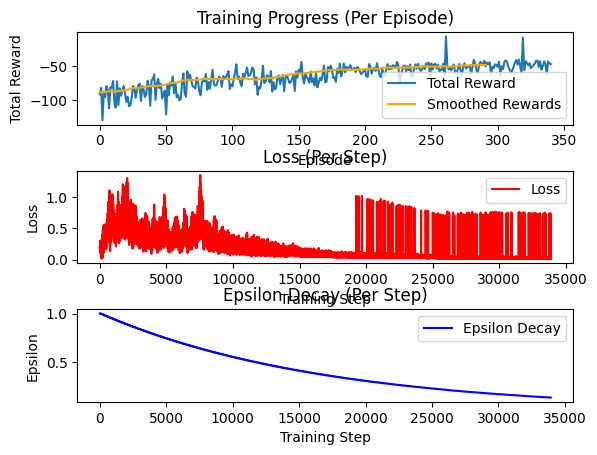

<Figure size 640x480 with 0 Axes>

Episode 341/500, Total Reward: -47.14628015860026
Loss: 0.03204478603013817
Loss: 0.018718940325057568
Loss: 0.02492732807782039
Loss: 0.02374537461218361
Loss: 0.01261069709890619
Loss: 0.021360003286585064
Loss: 0.01960909940741232
Loss: 0.020009989063504974
Loss: 0.02527471963386955
Loss: 0.024417639870766998
Loss: 0.018209643717660443
Loss: 0.024310754678256344
Loss: 0.016479477903846462
Loss: 0.019031849661282234
Loss: 0.020705137905577934
Loss: 0.011668913195372697
Loss: 0.015873852170446495
Loss: 0.018349368463239955
Loss: 0.015235723006633966
Loss: 0.7444006521977254
Loss: 0.01505118690442482
Loss: 0.01695419715728718
Loss: 0.015749241805539223
Loss: 0.017345328830743773
Loss: 0.02139484301955888
Loss: 0.020069822057124955
Loss: 0.0229047548778388
Loss: 0.01651311668501837
Loss: 0.014451349300951353
Loss: 0.021198332145616408
Loss: 0.016497300413731618
Loss: 0.015965716991363992
Loss: 0.020872264550802926
Loss: 0.018709145013442417
Loss: 0.020302568005256417
Loss: 0.01622728914

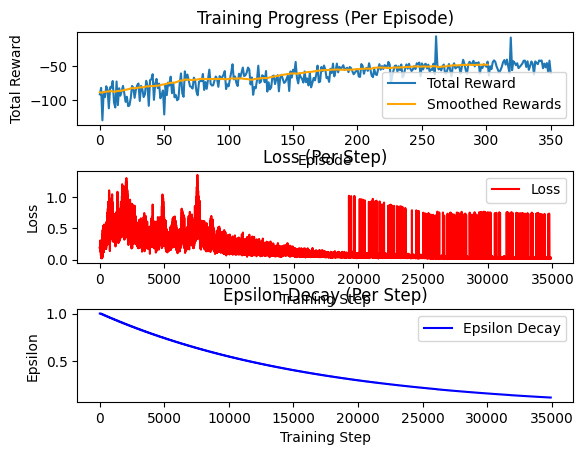

<Figure size 640x480 with 0 Axes>

Episode 351/500, Total Reward: -59.72880132633269
Loss: 0.015537600964068313
Loss: 0.023503525954963543
Loss: 0.018906204529561724
Loss: 0.01364348469330728
Loss: 0.02485633325903838
Loss: 0.019386526427900654
Loss: 0.021922303459416766
Loss: 0.018759202794992005
Loss: 0.020456488896128604
Loss: 0.01228559358938961
Loss: 0.01765035994879209
Loss: 0.024436150745376705
Loss: 0.013828078969873592
Loss: 0.025100729899859488
Loss: 0.01976917973347826
Loss: 0.023810598685058255
Loss: 0.01892108995069547
Loss: 0.01394142543006151
Loss: 0.018384032917484215
Loss: 0.012257246659747697
Loss: 0.023499923834988865
Loss: 0.018947466292086892
Loss: 0.02178001630650217
Loss: 0.01984797471923113
Loss: 0.02290454261721156
Loss: 0.016461422722425456
Loss: 0.02029028391131265
Loss: 0.01797275345379494
Loss: 0.018695253256923186
Loss: 0.020865749127645567
Loss: 0.012565399067117702
Loss: 0.02092017933487559
Loss: 0.018545610197526746
Loss: 0.017935574513461876
Loss: 0.013797563954129366
Loss: 0.0202786998

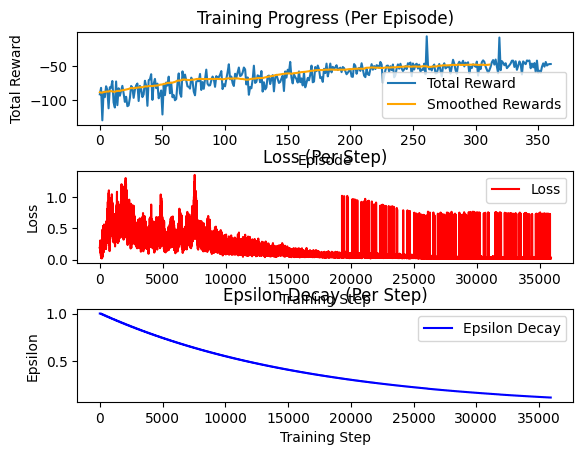

<Figure size 640x480 with 0 Axes>

Episode 361/500, Total Reward: -47.000435407992285
Loss: 0.02378194909539704
Loss: 0.026421995041294326
Loss: 0.025818623972070822
Loss: 0.020289582832003904
Loss: 0.02016946742797821
Loss: 0.03034060071433009
Loss: 0.018424002679551535
Loss: 0.01619354999004488
Loss: 0.03838603718267085
Loss: 0.01566606353362121
Loss: 0.0223318900741529
Loss: 0.022411187147554593
Loss: 0.029989821326121425
Loss: 0.02198602202655586
Loss: 0.017783585693355634
Loss: 0.02735893952005017
Loss: 0.01928115269694988
Loss: 0.02238206270380391
Loss: 0.03011119942418068
Loss: 0.029503497097528225
Loss: 0.021281442744563693
Loss: 0.024289294478360382
Loss: 0.025950787812234206
Loss: 0.028385709727657193
Loss: 0.021061191018112345
Loss: 0.025372862990677945
Loss: 0.02109798192959063
Loss: 0.02552895073957597
Loss: 0.02021626070227131
Loss: 0.022397692365544713
Loss: 0.026847068172671417
Loss: 0.02469375004955028
Loss: 0.02030167231987729
Loss: 0.020247497538395387
Loss: 0.02168245426399313
Loss: 0.029145629127887

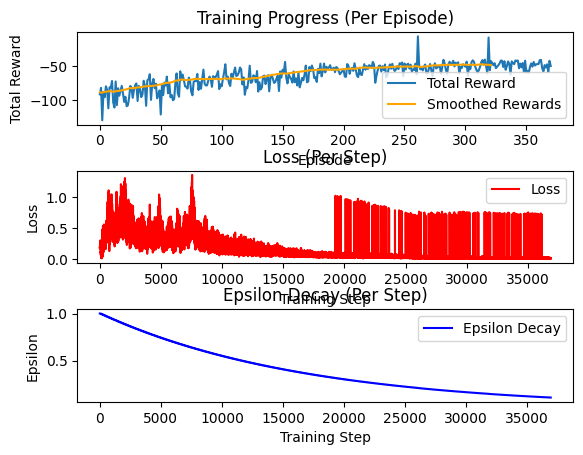

<Figure size 640x480 with 0 Axes>

Episode 371/500, Total Reward: -49.85351571920666
Loss: 0.021173803217898468
Loss: 0.01365757324470507
Loss: 0.019401048683034716
Loss: 0.015625564357571696
Loss: 0.015456326871533114
Loss: 0.02170162019655697
Loss: 0.017929733870475396
Loss: 0.014419815810016296
Loss: 0.015671205764781
Loss: 0.014737344335027264
Loss: 0.018897338774026162
Loss: 0.013039664283204126
Loss: 0.011228619598391196
Loss: 0.015180933988043195
Loss: 0.020661626335486558
Loss: 0.017729131421881775
Loss: 0.014249963201403135
Loss: 0.0151525174870353
Loss: 0.01835128826397297
Loss: 0.01656927390125524
Loss: 0.01642255122824722
Loss: 0.014976579695344728
Loss: 0.01411624971328242
Loss: 0.019136485326560718
Loss: 0.009296196876325973
Loss: 0.014171342581826393
Loss: 0.01431270166115034
Loss: 0.015676088696119264
Loss: 0.017028599993257246
Loss: 0.014311903125719342
Loss: 0.01477036245562144
Loss: 0.020767450635102297
Loss: 0.014127107369002675
Loss: 0.019358034783929806
Loss: 0.01712942822770816
Loss: 0.02014005460

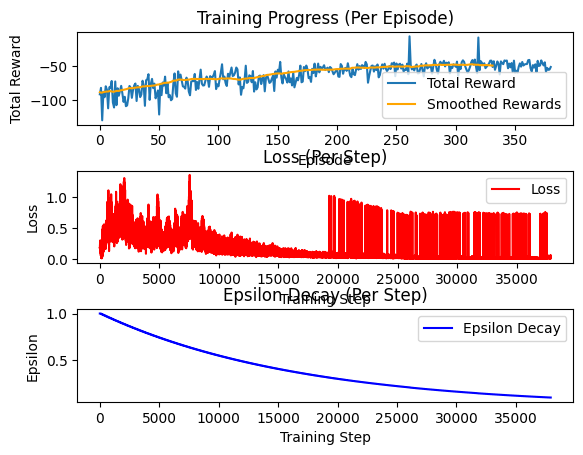

<Figure size 640x480 with 0 Axes>

Episode 381/500, Total Reward: -51.335906980937935
Loss: 0.03918397576139316
Loss: 0.05342096073803462
Loss: 0.04466706581222406
Loss: 0.039738911833485525
Loss: 0.024973252630653427
Loss: 0.01754699730865782
Loss: 0.024237752945477822
Loss: 0.02451110500859629
Loss: 0.020999774251506197
Loss: 0.043801236460690576
Loss: 0.028542123785250707
Loss: 0.047454295513424664
Loss: 0.060139364710582635
Loss: 0.0516558277905937
Loss: 0.03349901606000671
Loss: 0.030879071391154832
Loss: 0.03939186526228483
Loss: 0.02355959463623756
Loss: 0.025487652043317793
Loss: 0.04447678706418996
Loss: 0.02323720370789028
Loss: 0.05892014291945957
Loss: 0.030625786514307255
Loss: 0.03415800942028396
Loss: 0.03111430825808456
Loss: 0.016955557353715463
Loss: 0.021287853031984307
Loss: 0.019189334023629184
Loss: 0.02895922743319005
Loss: 0.05126118724142337
Loss: 0.02266550231750413
Loss: 0.04603380682040905
Loss: 0.09185289322538631
Loss: 0.033990778811843654
Loss: 0.04995641509075044
Loss: 0.04647352693870389

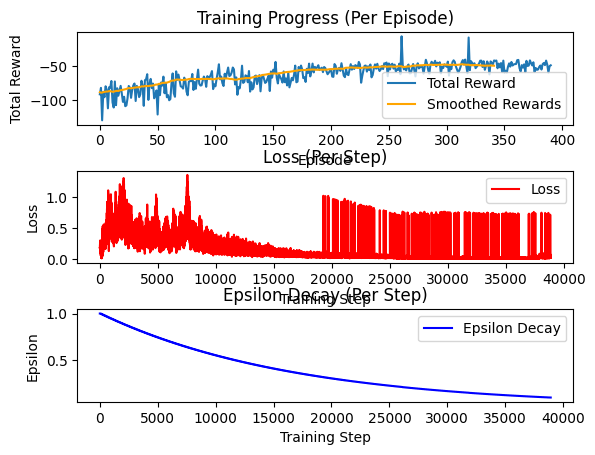

<Figure size 640x480 with 0 Axes>

Episode 391/500, Total Reward: -48.86818269851323
Loss: 0.03549996700775497
Loss: 0.07052072486074488
Loss: 0.07520380517183975
Loss: 0.03626168106108818
Loss: 0.04076463175164216
Loss: 0.029126082093057715
Loss: 0.03027802388829587
Loss: 0.0528214276178325
Loss: 0.03630891063865344
Loss: 0.029574446791612134
Loss: 0.039407637022921646
Loss: 0.04107205565960482
Loss: 0.03650543364913893
Loss: 0.068302759537031
Loss: 0.03733937003913555
Loss: 0.03597765667848907
Loss: 0.044194265196199845
Loss: 0.04145024093024616
Loss: 0.04975371967925872
Loss: 0.03642121427028876
Loss: 0.05031630629911828
Loss: 0.05297947860376692
Loss: 0.04693822074251564
Loss: 0.06501668340023181
Loss: 0.04783856925361661
Loss: 0.038684414697673065
Loss: 0.02380598759273567
Loss: 0.028426077015329683
Loss: 0.02619815722680091
Loss: 0.04468776861152151
Loss: 0.034711231974923186
Loss: 0.06504558275918193
Loss: 0.04403695703077328
Loss: 0.03575276144742895
Loss: 0.031074421643448123
Loss: 0.021331118960504075
Loss: 0.

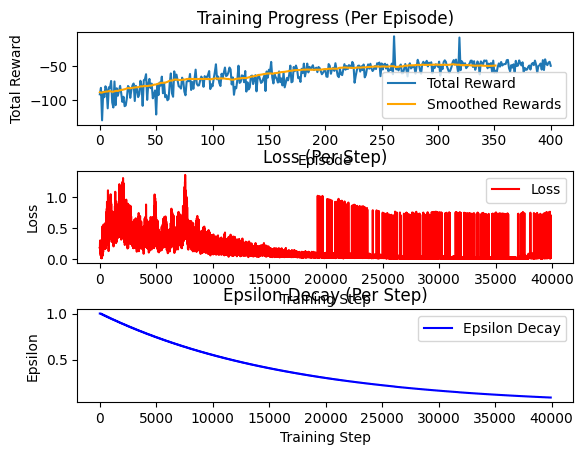

<Figure size 640x480 with 0 Axes>

Episode 401/500, Total Reward: -49.57592453203664
Loss: 0.03447289217675584
Loss: 0.04267594845139454
Loss: 0.031604494674369404
Loss: 0.03681971167759723
Loss: 0.03656862105564407
Loss: 0.025708601782024353
Loss: 0.03530855042226577
Loss: 0.03579987468579521
Loss: 0.029888208364700977
Loss: 0.03413622833278138
Loss: 0.03758133446232966
Loss: 0.045825536877989896
Loss: 0.040850802436298336
Loss: 0.027753595608136818
Loss: 0.028513763017751367
Loss: 0.03148466896930892
Loss: 0.024648705320653892
Loss: 0.023272152120908815
Loss: 0.04102729566225561
Loss: 0.024344171709799838
Loss: 0.02980365922226424
Loss: 0.039969651687288096
Loss: 0.052316004167634024
Loss: 0.037125501502618605
Loss: 0.03246111500069479
Loss: 0.029464055798539772
Loss: 0.041233091286913576
Loss: 0.020890352931026028
Loss: 0.021097453008805132
Loss: 0.029213682482166534
Loss: 0.03604397666280082
Loss: 0.04352377214939377
Loss: 0.03984614065515619
Loss: 0.032983386821200056
Loss: 0.02466544182746858
Loss: 0.0267064262001

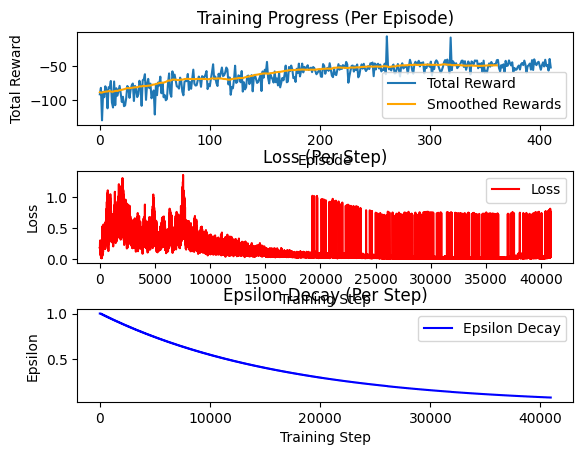

<Figure size 640x480 with 0 Axes>

Episode 411/500, Total Reward: -52.048094991158166
Loss: 0.04020486319332725
Loss: 0.12477885328456012
Loss: 0.09277248130782602
Loss: 0.09209950273578818
Loss: 0.060794302978641565
Loss: 0.05162101714986384
Loss: 0.05098380096663066
Loss: 0.04105281423554326
Loss: 0.0471738595932087
Loss: 0.0633107395241172
Loss: 0.10751129976369313
Loss: 0.11388091527912705
Loss: 0.06644630805358363
Loss: 0.05450606169069588
Loss: 0.05340285584106759
Loss: 0.05907676342115774
Loss: 0.0490229295911268
Loss: 0.06404206570980302
Loss: 0.733904039274986
Loss: 0.04988762703206689
Loss: 0.043933289245081275
Loss: 0.12516701342107917
Loss: 0.08470538181241051
Loss: 0.09714236419411915
Loss: 0.06033019629988233
Loss: 0.06408634916339268
Loss: 0.05951059280303056
Loss: 0.09143915433417668
Loss: 0.057668160285076646
Loss: 0.059743789511311235
Loss: 0.04300370871030244
Loss: 0.1155267185145615
Loss: 0.10851134196311357
Loss: 0.07056366178622969
Loss: 0.036480266121068756
Loss: 0.06412287965244624
Loss: 0.059514

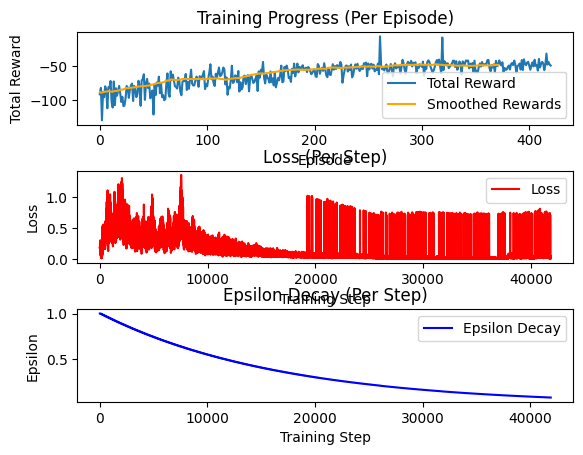

<Figure size 640x480 with 0 Axes>

Episode 421/500, Total Reward: -49.178895658278456
Loss: 0.022775817278869494
Loss: 0.0362863597153845
Loss: 0.018088439312903368
Loss: 0.036234719724549405
Loss: 0.024026940887674465
Loss: 0.020995347728379736
Loss: 0.031380839875124814
Loss: 0.02558146378565678
Loss: 0.02268684859828221
Loss: 0.01813171595391879
Loss: 0.024584079590242322
Loss: 0.03715057471943702
Loss: 0.039943331793610565
Loss: 0.03701260110513748
Loss: 0.023323492095386346
Loss: 0.027436847315262622
Loss: 0.03975186783841038
Loss: 0.039786851867553666
Loss: 0.025778297223577763
Loss: 0.012334937336594886
Loss: 0.019469214647218368
Loss: 0.02689970615570183
Loss: 0.040219335972762046
Loss: 0.03936997698010541
Loss: 0.026232888649944996
Loss: 0.03090244224196577
Loss: 0.019003541024530946
Loss: 0.6987852992233596
Loss: 0.037719474634600264
Loss: 0.04084110515345363
Loss: 0.02545092995892054
Loss: 0.0318709893207238
Loss: 0.028993539719572047
Loss: 0.0229411472519852
Loss: 0.023637790686375865
Loss: 0.025372486513020

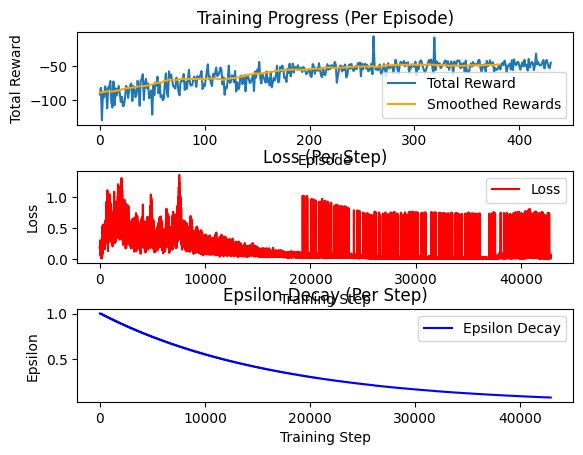

<Figure size 640x480 with 0 Axes>

Episode 431/500, Total Reward: -45.061051741032266
Loss: 0.04796712778427277
Loss: 0.06743636241117777
Loss: 0.05816767381965466
Loss: 0.04707521447536743
Loss: 0.04576318960384765
Loss: 0.022997510952280552
Loss: 0.02917220812219643
Loss: 0.025801625751475012
Loss: 0.025660000469247657
Loss: 0.0367546795864561
Loss: 0.042680899040182046
Loss: 0.06779752701258605
Loss: 0.06451826277420984
Loss: 0.03164770460385941
Loss: 0.031206155608751972
Loss: 0.039538863231700416
Loss: 0.037184811393554076
Loss: 0.029761033867404453
Loss: 0.0406634720204605
Loss: 0.051291570314523145
Loss: 0.7365952894547886
Loss: 0.049731341397739964
Loss: 0.0518487139922381
Loss: 0.0404634329637502
Loss: 0.028785600962256762
Loss: 0.04107881136573811
Loss: 0.03330368678875926
Loss: 0.03887746020485533
Loss: 0.042468902868885786
Loss: 0.028132632905488994
Loss: 0.049605769241785114
Loss: 0.06566021950658488
Loss: 0.050841155050639665
Loss: 0.04760639607137131
Loss: 0.039150163601328
Loss: 0.03269422485772666
Loss:

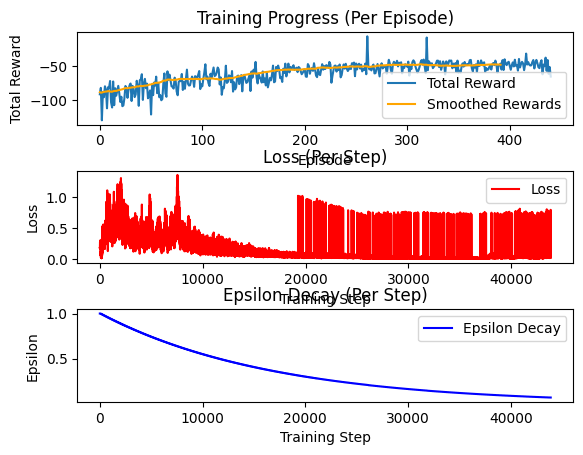

<Figure size 640x480 with 0 Axes>

Episode 441/500, Total Reward: -65.37440629192272
Loss: 0.08859466690738552
Loss: 0.08512819076744929
Loss: 0.09716569829070797
Loss: 0.06872652135488773
Loss: 0.737955884899059
Loss: 0.06306864461175515
Loss: 0.05902558540646072
Loss: 0.06640572087972607
Loss: 0.10947332501969445
Loss: 0.04420466669434974
Loss: 0.027730417908915617
Loss: 0.07506869872367876
Loss: 0.09126361663833227
Loss: 0.06805404565550964
Loss: 0.05588876445640021
Loss: 0.06628738178273619
Loss: 0.07150657134349121
Loss: 0.07198324189756147
Loss: 0.04990295861888572
Loss: 0.07681609920271483
Loss: 0.054257061230574916
Loss: 0.10992983922206123
Loss: 0.08826451996073958
Loss: 0.11790331528375934
Loss: 0.09370599114842545
Loss: 0.04197880001548508
Loss: 0.05739055184337811
Loss: 0.09591876273811366
Loss: 0.03501127899682608
Loss: 0.03976521132584297
Loss: 0.06676370611275464
Loss: 0.08998357685214298
Loss: 0.8833305889433658
Loss: 0.09205423025275539
Loss: 0.06761983038781906
Loss: 0.06278261842065977
Loss: 0.0461716

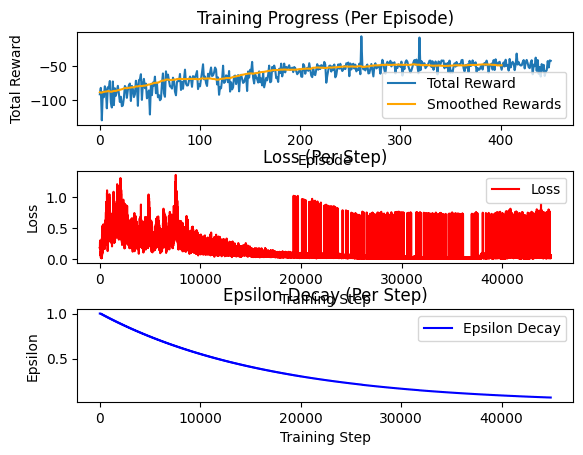

<Figure size 640x480 with 0 Axes>

Episode 451/500, Total Reward: -42.279900595247135
Loss: 0.0312817686277249
Loss: 0.05339211866812994
Loss: 0.05643585037425907
Loss: 0.05935869097237553
Loss: 0.05371435493353212
Loss: 0.03878527146092328
Loss: 0.027665683732163538
Loss: 0.026873499594641116
Loss: 0.028771882002064396
Loss: 0.020836042643277375
Loss: 0.029566486242487096
Loss: 0.04742325701682833
Loss: 0.05344414679822014
Loss: 0.04011946862949996
Loss: 0.05166794014560395
Loss: 0.02178414898208708
Loss: 0.041699124754892146
Loss: 0.03271634526206621
Loss: 0.03366949393083578
Loss: 0.057628064309738186
Loss: 0.027046865105164623
Loss: 0.05355805375656378
Loss: 0.04309003357249937
Loss: 0.05263647876539644
Loss: 0.03550989564691954
Loss: 0.039057455013595616
Loss: 0.02376576140210492
Loss: 0.0567448370298346
Loss: 0.03211867099483631
Loss: 0.040238558195422464
Loss: 0.025519694909560638
Loss: 0.0714340382987423
Loss: 0.0756317388953428
Loss: 0.049588958711839
Loss: 0.04393492176336196
Loss: 0.035853501452850656
Loss: 0

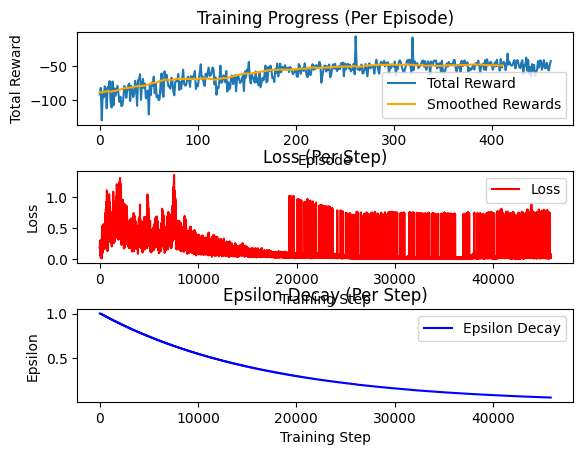

<Figure size 640x480 with 0 Axes>

Episode 461/500, Total Reward: -42.65240177047405
Loss: 0.06783380143656145
Loss: 0.06823007573233925
Loss: 0.07802536598617296
Loss: 0.03845994945565705
Loss: 0.05873150069968313
Loss: 0.7757819445555567
Loss: 0.04366745491599976
Loss: 0.038162630396925565
Loss: 0.030113144686671388
Loss: 0.05756993296639307
Loss: 0.04462160512065068
Loss: 0.05605020617511094
Loss: 0.050360354310059724
Loss: 0.06405959258217395
Loss: 0.031064987118741134
Loss: 0.027711360489541825
Loss: 0.03224159678135312
Loss: 0.02166129897512732
Loss: 0.058500519377950505
Loss: 0.024541671582471995
Loss: 0.025889202879240396
Loss: 0.07054100306827289
Loss: 0.756436027660423
Loss: 0.06481336537681262
Loss: 0.04622661303643316
Loss: 0.036983150830703145
Loss: 0.03794117251953165
Loss: 0.05190142840890214
Loss: 0.02920709023717985
Loss: 0.061163096515442085
Loss: 0.04668478612310839
Loss: 0.07495408300232352
Loss: 0.08619090747180691
Loss: 0.06694062975804416
Loss: 0.03308706795597813
Loss: 0.04975571954946788
Loss: 0

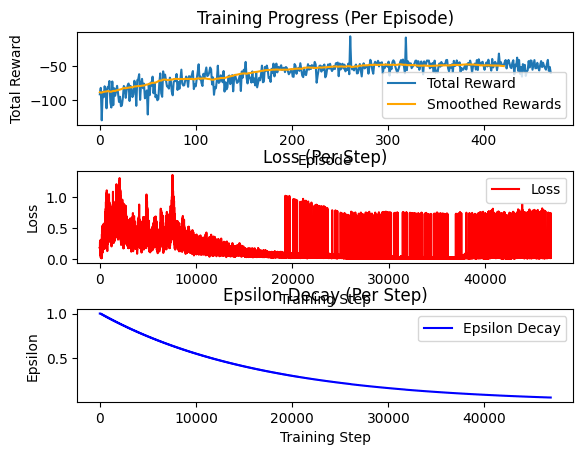

<Figure size 640x480 with 0 Axes>

Episode 471/500, Total Reward: -59.8443245808442
Loss: 0.038579591460816166
Loss: 0.08446601132623477
Loss: 0.0621059681563392
Loss: 0.0891647514306467
Loss: 0.04328122517682896
Loss: 0.03745568816952668
Loss: 0.02770663284796827
Loss: 0.022477227548666927
Loss: 0.06810868706209282
Loss: 0.03310467610244879
Loss: 0.04647551064869199
Loss: 0.09037792050475513
Loss: 0.05969761923028302
Loss: 0.06804679207815209
Loss: 0.032698260765004164
Loss: 0.033903808610785166
Loss: 0.03144390465976094
Loss: 0.04297718814611214
Loss: 0.03746769752704294
Loss: 0.01954444157917174
Loss: 0.032410619672668395
Loss: 0.05075228074479471
Loss: 0.06066948278639034
Loss: 0.0444178022186003
Loss: 0.043618557727568466
Loss: 0.035223586033018846
Loss: 0.0419622974373308
Loss: 0.04326558530046554
Loss: 0.03325212574224428
Loss: 0.02950327103443953
Loss: 0.031160377183965006
Loss: 0.05402300680129102
Loss: 0.044303636372727453
Loss: 0.038718008728844525
Loss: 0.035980295333712185
Loss: 0.04470557136039145
Loss: 0.

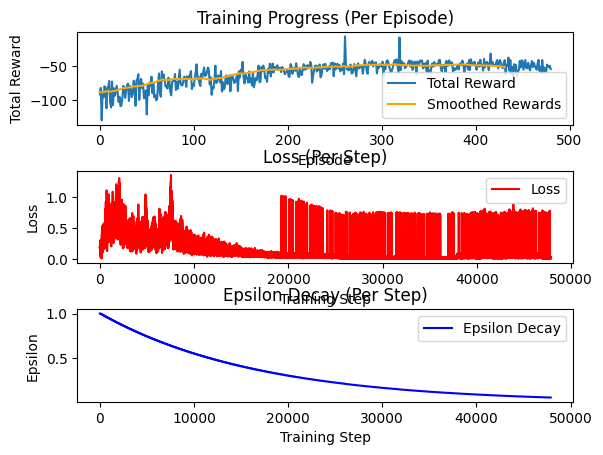

<Figure size 640x480 with 0 Axes>

Episode 481/500, Total Reward: -54.37873126117914
Loss: 0.016259373188623423
Loss: 0.038317407853916734
Loss: 0.030428224260862773
Loss: 0.048350948341476185
Loss: 0.036985894811186505
Loss: 0.021958458210452586
Loss: 0.01605949438597634
Loss: 0.03201751461160399
Loss: 0.036010123888314746
Loss: 0.02218531826700757
Loss: 0.02709224553623212
Loss: 0.03819088461591664
Loss: 0.037803758823645936
Loss: 0.033380114425484844
Loss: 0.02312449293067318
Loss: 0.020702865763606984
Loss: 0.022770184927321455
Loss: 0.021861540470365568
Loss: 0.021380812077614775
Loss: 0.046395591985499245
Loss: 0.023440437472976174
Loss: 0.034064839496971706
Loss: 0.03245351054164779
Loss: 0.029224293875821046
Loss: 0.025228277610359694
Loss: 0.017175684398264897
Loss: 0.023777689952382865
Loss: 0.031460847002445405
Loss: 0.017642684058780694
Loss: 0.02791690006559168
Loss: 0.035814299131029514
Loss: 0.032681599490007
Loss: 0.7462700124571673
Loss: 0.0313453719335471
Loss: 0.023858041694825076
Loss: 0.023124950170

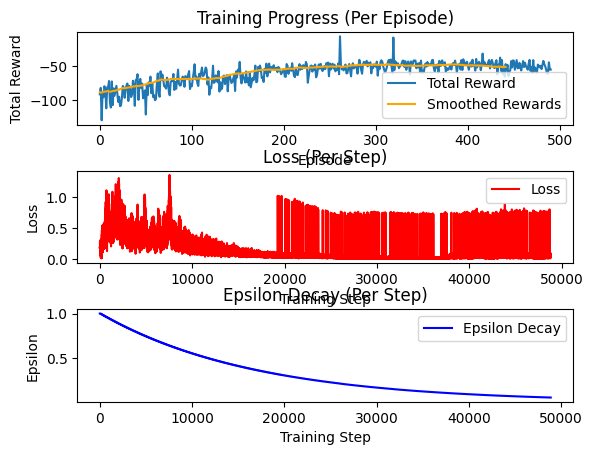

<Figure size 640x480 with 0 Axes>

Episode 491/500, Total Reward: -55.10496604389867
Loss: 0.04112318459010971
Loss: 0.07227387395972501
Loss: 0.08896289119685527
Loss: 0.06856774588780715
Loss: 0.05848837529487397
Loss: 0.05113535853362625
Loss: 0.04740808512460348
Loss: 0.0487780009500445
Loss: 0.060014059341262097
Loss: 0.0501237727127228
Loss: 0.05314900728090383
Loss: 0.09878192287442865
Loss: 0.0584560167659932
Loss: 0.07286982156548508
Loss: 0.03639216869107561
Loss: 0.026939603758224087
Loss: 0.05429653887058093
Loss: 0.02849775425972132
Loss: 0.08674587040193363
Loss: 0.06459431004261079
Loss: 0.03985117438371154
Loss: 0.09311801716243578
Loss: 0.054963283884706615
Loss: 0.040785170589508694
Loss: 0.05490940065083849
Loss: 0.022129217628759672
Loss: 0.02675953822915096
Loss: 0.02059363588472074
Loss: 0.04808722132665409
Loss: 0.03061375905930836
Loss: 0.042896959599125775
Loss: 0.05698302506101452
Loss: 0.0595249916089501
Loss: 0.03274828592431457
Loss: 0.06651764224154394
Loss: 0.050412871537468346
Loss: 0.042

In [ ]:
duration = 100

def update_target_network(t):
    if t % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

for i_episode in range(num_episodes):
    # Initialize the environment and get the initial state
    observation, info = env.reset()
    observation_vector = process_observation(observation)
    observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0  # Track the total reward for this episode
    for t in range(duration):
        # Select an action
        action_index = select_action(observation_tensor, i_episode)
        action = candidate_actions[action_index.item()]

        # Perform the action and observe the result
        observation, reward, terminated, truncated, _ = env.step(action.numpy())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()

        # Check if the episode is done
        done = terminated or truncated

        # Process the next state
        if not done:
            observation_vector = process_observation(observation)
            next_observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_observation_tensor = None

        # Store the experience in memory
        memory.push(observation_tensor, action_index, next_observation_tensor, reward)

        # Update the current state
        observation_tensor = next_observation_tensor

        # Optimize the policy network
        optimize_policy_net()

        # Update the target network
        update_target_network(t)

        # If the episode is done, record the result and break the loop
        if done or t == duration - 1:
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)

            if truncated:
                print(f"Episode {i_episode + 1} truncated after {t + 1} steps")
            elif terminated:
                print(f"Episode {i_episode + 1} finished after {t + 1} steps")

            if i_episode % 10 == 0:
                plot_training_durations()
            break

    print(f"Episode {i_episode + 1}/{num_episodes}, Total Reward: {episode_rewards[i_episode]}")

print('Training is finished')
plt.ioff()
plt.show()

In [ ]:
env.close()

In [ ]:
torch.save(policy_net.state_dict(), 'policy_net.pth')
torch.save(target_net.state_dict(), 'target_net.pth')

In [ ]:
# sam

## test